In [1]:
import os, platform, pprint, sys
import fastai
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sklearn
import yellowbrick as yb

from fastai.tabular.data import TabularDataLoaders, TabularPandas
from fastai.tabular.all import FillMissing, Categorify, Normalize, tabular_learner, accuracy, ClassificationInterpretation, ShowGraphCallback, RandomSplitter, range_of

from sklearn.base import BaseEstimator
from sklearn.metrics import accuracy_score, classification_report
from sklearn.neighbors import KNeighborsClassifier

from yellowbrick.model_selection import CVScores, LearningCurve, ValidationCurve


seed: int = 14


# set up pretty printer for easier data evaluation
pretty = pprint.PrettyPrinter(indent=4, width=30).pprint


# declare file paths for the data we will be working on
data_path_1: str = '../data/prepared/baseline/'
data_path_2: str = '../data/prepared/timebased/'
modelPath  : str = './models'


# list the names of the datasets we will be using
attacks : list = [ 'DNS', 'LDAP', 'MSSQL', 'NetBIOS', 'NTP', 'Portmap', 'SNMP', 'SSDP', 'Syn', 'TFTP', 'UDP', 'UDPLag' ]
datasets: list = [
    "DNS_vs_benign.csv" , "LDAP_vs_benign.csv"    , "MSSQL_vs_benign.csv" , "NetBIOS_vs_benign.csv" ,
    "NTP_vs_benign.csv" , "Portmap_vs_benign.csv" , "SNMP_vs_benign.csv"  , "SSDP_vs_benign.csv"    ,
    "Syn_vs_benign.csv" , "TFTP_vs_benign.csv"    , "UDP_vs_benign.csv"   , "UDPLag_vs_benign.csv"  ,
]


# enumerate dataset types
Baseline : int = 0
Timebased: int = 1


# print library and python versions for reproducibility
print(
    f'''
    python:\t{platform.python_version()}

    \tfastai:\t\t{fastai.__version__}
    \tmatplotlib:\t{mpl.__version__}
    \tnumpy:\t\t{np.__version__}
    \tpandas:\t\t{pd.__version__}
    \tsklearn:\t{sklearn.__version__}
    \tyellowbrick:\t{yb.__version__}
    '''
)


    python:	3.7.10

    	fastai:		2.4.1
    	matplotlib:	3.3.4
    	numpy:		1.20.3
    	pandas:		1.2.5
    	sklearn:	0.24.2
    	yellowbrick:	1.3.post1
    


In [2]:
def get_file_path(directory: str):
    '''
        Closure that will return a function that returns the filepath to the directory given to the closure
    '''

    def func(file: str) -> str:
        return os.path.join(directory, file)

    return func


# use the get_file_path closure to create a function that will return the path to a file
baseline_path  = get_file_path(data_path_1)
timebased_path = get_file_path(data_path_2)


# create a list of the paths to all of the dataset files
baseline_files : list = list(map(baseline_path , datasets))
timebased_files: list = list(map(timebased_path, datasets))

In [3]:
def load_data(filePath: str) -> pd.DataFrame:
    '''
        Loads the Dataset from the given filepath and caches it for quick access in the future
        Function will only work when filepath is a .csv file
    '''

    # slice off the ./CSV/ from the filePath
    if filePath[0] == '.' and filePath[1] == '.':
        filePathClean: str = filePath[17::]
        pickleDump: str = f'../data/cache/{filePathClean}.pickle'
    else:
        pickleDump: str = f'../data/cache/{filePath}.pickle'
    
    print(f'Loading Dataset: {filePath}')
    print(f'\tTo Dataset Cache: {pickleDump}\n')
    
    # check if data already exists within cache
    # if not, load data and cache it
    if os.path.exists(pickleDump):
        df = pd.read_pickle(pickleDump)
    else:
        df = pd.read_csv(filePath, low_memory=True)
        df.to_pickle(pickleDump)
    
    return df


class SklearnWrapper(BaseEstimator):
    '''
        A wrapper for fastai learners for creating visualizations using yellowbrick
        code sourced from: 
        forums.fast.ai/t/fastai-with-yellowbrics-how-to-get-roc-curves-more/79408
    '''
    _estimator_type = "classifier"
        
    def __init__(self, model):
        self.model = model
        self.classes_ = list(self.model.dls.y.unique())
    
    def fit(self, X, y):
        pass
        
    def score(self, X, y):
        return accuracy_score(y, self.predict(X))
    
    def get_new_preds(self, X):
        new_to = self.model.dls.valid_ds.new(X)
        new_to.conts = new_to.conts.astype(np.float32)
        new_dl = self.model.dls.valid.new(new_to)
        with self.model.no_bar():
            preds,_,dec_preds = self.model.get_preds(dl=new_dl, with_decoded=True)
        return (preds, dec_preds)

    def predict_proba(self, X):
        return self.get_new_preds(X)[0].numpy()
    
    def predict(self, X):
        return self.get_new_preds(X)[1].numpy()

In [4]:
def run_experiment(df: pd.DataFrame, name: str) -> tuple:
    '''
        Run binary classification on a given dataframe, saving the model as {name}.model
        returns the 7-tuple with the following indicies:
        viz_data: tuple = (name, model, classes, X_train, y_train, X_test, y_test)
    '''

    print(f'{name}: {df.shape}')
    
    # First we split the features into the dependent variable and 
    # continous and categorical features
    dep_var: str = 'Label'
    if 'Protocol' in df.columns:
        categorical_features: list = ['Protocol']
    else:
        categorical_features: list = []
    continuous_features = list(set(df) - set(categorical_features) - set([dep_var]))

    # Next, we set up the feature engineering pipeline, namely filling missing values
    # encoding categorical features, and normalizing the continuous features
    # all within a pipeline to prevent the normalization from leaking details
    # about the test sets through the normalized mapping of the training sets
    procs = [FillMissing, Categorify, Normalize]
    splits = RandomSplitter(valid_pct=0.2, seed=seed)(range_of(df))
    
    # The dataframe is loaded into a fastai datastructure now that 
    # the feature engineering pipeline has been set up
    to = TabularPandas(
        df            , y_names=dep_var                , 
        splits=splits , cat_names=categorical_features ,
        procs=procs   , cont_names=continuous_features , 
    )

    # The dataframe is then converted into a fastai dataset
    dls = to.dataloaders(bs=64)

    # Next, we set up, train, and save the deep neural network
    model = tabular_learner(dls, layers=[80, 30], metrics=accuracy, cbs=ShowGraphCallback)
    model.fit_one_cycle(10)
    model.save(f'{name}.model')

    # We print the results of the training    
    loss, acc = model.validate()
    print('loss {}: accuracy: {:.2f}%'.format(loss, acc*100))

    # We extract the training and test datasets from the dataframe
    X_train = to.train.xs.reset_index(drop=True)
    X_test = to.valid.xs.reset_index(drop=True)
    y_train = to.train.ys.values.ravel()
    y_test = to.valid.ys.values.ravel()

    # We wrap our model to make it look like a scikitlearn model
    # for visualization using yellowbrick
    wrapped_model = SklearnWrapper(model)

    # we add a target_type_ attribute to our model so yellowbrick knows how to make the visualizations
    classes = list(model.dls.vocab)
    if len(classes) == 2:
        wrapped_model.target_type_ = 'binary'
    elif len(classes) > 2:  
        wrapped_model.target_type_ = 'multiclass'
    else:
        print('Must be more than one class to perform classification')
        raise ValueError('Wrong number of classes')
    
    # Now that the classifier has been created and trained, we pass out our training values
    # so that yellowbrick can use them to create various visualizations
    viz_data: tuple = (name, wrapped_model, classes, X_train, y_train, X_test, y_test)

    return viz_data


def visualize_confusion_matrix(viz_data: tuple) -> None:
    '''
        Takes a 7-tuple from the run_experiments function and creates a confusion matrix

        viz_data: tuple = (name, model, classes, X_train, y_train, X_test, y_test)
    '''

    visualizer = yb.classifier.ConfusionMatrix(viz_data[1], classes=viz_data[2], title=viz_data[0])
    visualizer.score(viz_data[5], viz_data[6])
    visualizer.show()


def visualize_roc(viz_data: tuple) -> None:
    '''
        Takes a 7-tuple from the run_experiments function and creates a 
        Receiver Operating Characteristic (ROC) Curve

        viz_data: tuple = (name, model, classes, X_train, y_train, X_test, y_test)
    '''

    visualizer = yb.classifier.ROCAUC(viz_data[1], classes=viz_data[2], title=viz_data[0])
    visualizer.score(viz_data[5], viz_data[6])
    visualizer.poof()


def visualize_pr_curve(viz_data: tuple) -> None:
    '''
        Takes a 7-tuple from the run_experiments function and creates a 
        Precision-Recall Curve

        viz_data: tuple = (name, model, classes, X_train, y_train, X_test, y_test)
    '''

    visualizer = yb.classifier.PrecisionRecallCurve(viz_data[1], title=viz_data[0])
    visualizer.score(viz_data[5], viz_data[6])
    visualizer.poof()


def visualize_report(viz_data: tuple) -> None:
    '''
        Takes a 7-tuple from the run_experiments function and creates a report
        detailing the Precision, Recall, f1, and Support scores for all 
        classification outcomes

        viz_data: tuple = (name, model, classes, X_train, y_train, X_test, y_test)
    '''

    visualizer = yb.classifier.ClassificationReport(viz_data[1], classes=viz_data[2], title=viz_data[0], support=True)
    visualizer.score(viz_data[5], viz_data[6])
    visualizer.poof()


def visualize_class_balance(viz_data: tuple) -> None:
    '''
        Takes a 7-tuple from the run_experiments function and creates a histogram
        detailing the balance between classification outcomes

        viz_data: tuple = (name, model, classes, X_train, y_train, X_test, y_test)
    '''

    visualizer = yb.target.ClassBalance(labels=viz_data[0])
    visualizer.fit(viz_data[4], viz_data[6])
    visualizer.show()

In [5]:
baseline_dfs : map = map(load_data   , baseline_files )
timebased_dfs: map = map(load_data   , timebased_files)
experiments  : zip = zip(baseline_dfs, timebased_dfs  , attacks)

In [6]:
def experiment_runner():
    '''
        A generator that handles running the experiments
    '''
    num = 1
    for baseline, timebased, info in experiments:
        print(f'Running experiment #{num}:\t{info}')

        print('Baseline results')
        baseline_results = run_experiment(baseline, f'{info}_vs_benign_baseline')
        
        print('\nTime-based results')
        timebased_results = run_experiment(timebased, f'{info}_vs_benign_timebased')
        
        num += 1
        yield (baseline_results, timebased_results, info, num)


experiment = experiment_runner()

## Experiment #1: DNS vs Benign

Loading Dataset: ../data/prepared/baseline/DNS_vs_benign.csv
	To Dataset Cache: ../data/cache/baseline/DNS_vs_benign.csv.pickle

Loading Dataset: ../data/prepared/timebased/DNS_vs_benign.csv
	To Dataset Cache: ../data/cache/timebased/DNS_vs_benign.csv.pickle

Running experiment #1:	DNS
Baseline results
DNS_vs_benign_baseline: (225462, 70)


epoch,train_loss,valid_loss,accuracy,time
0,0.004595,0.231684,0.997827,00:23
1,0.006674,0.094268,0.998093,00:23
2,0.002447,0.012554,0.999335,00:23
3,0.002030,0.095842,0.993413,00:23
4,0.002623,0.102601,0.999645,00:23
5,0.003542,0.078989,0.999712,00:23
6,0.002299,0.139649,0.984321,00:23
7,0.000945,0.155123,0.979375,00:23
8,0.003141,0.070611,0.998802,00:23
9,0.002381,0.213840,0.978621,00:23


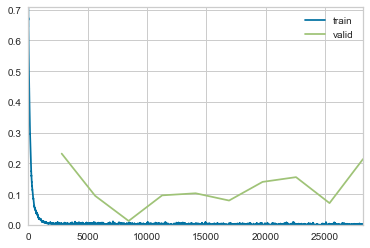

loss 0.2138400673866272: accuracy: 97.86%

Time-based results
DNS_vs_benign_timebased: (225462, 26)


epoch,train_loss,valid_loss,accuracy,time
0,0.079909,0.267371,0.913133,00:21
1,0.044304,0.169470,0.919476,00:21
2,0.042519,0.140336,0.921826,00:21
3,0.033313,0.141652,0.924089,00:21
4,0.034643,0.199002,0.923224,00:21
5,0.025011,0.248091,0.919054,00:21
6,0.027923,0.203909,0.922447,00:21
7,0.023528,0.196386,0.919897,00:21
8,0.026142,0.206382,0.919121,00:21
9,0.030367,0.190880,0.919454,00:21


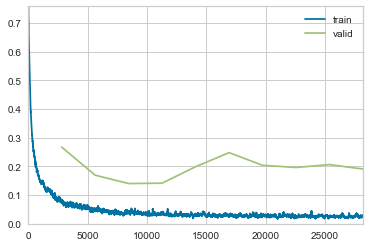

loss 0.19088000059127808: accuracy: 91.95%


In [7]:
results = next(experiment)

C:\ProgramData\Anaconda3\lib\site-packages\yellowbrick\classifier\base.py:234: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  YellowbrickWarning,


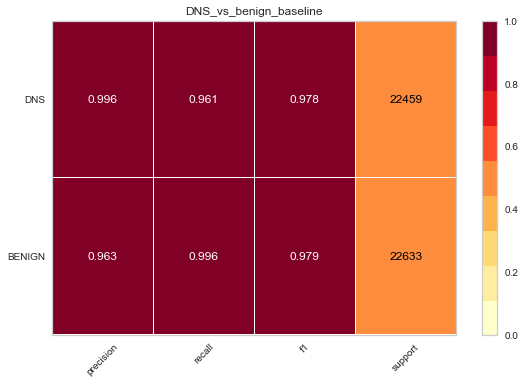

C:\ProgramData\Anaconda3\lib\site-packages\yellowbrick\classifier\base.py:234: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  YellowbrickWarning,


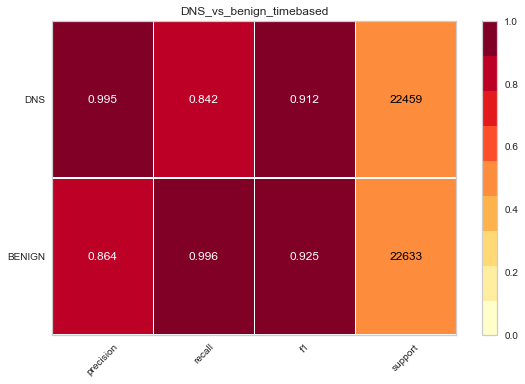

C:\ProgramData\Anaconda3\lib\site-packages\yellowbrick\classifier\base.py:234: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  YellowbrickWarning,


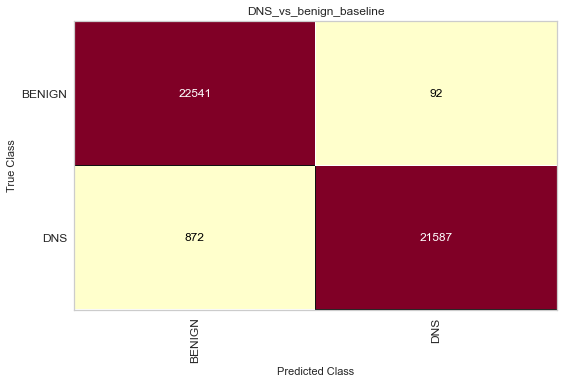

C:\ProgramData\Anaconda3\lib\site-packages\yellowbrick\classifier\base.py:234: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  YellowbrickWarning,


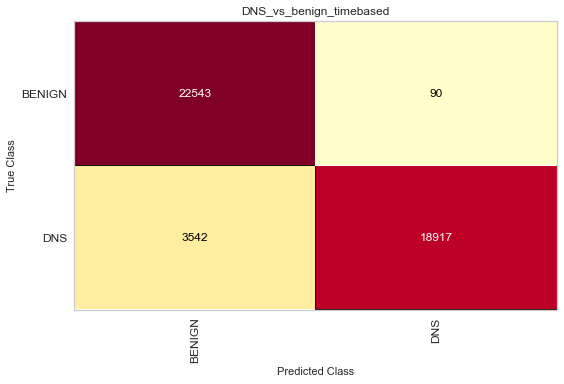

C:\ProgramData\Anaconda3\lib\site-packages\yellowbrick\classifier\base.py:234: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  YellowbrickWarning,


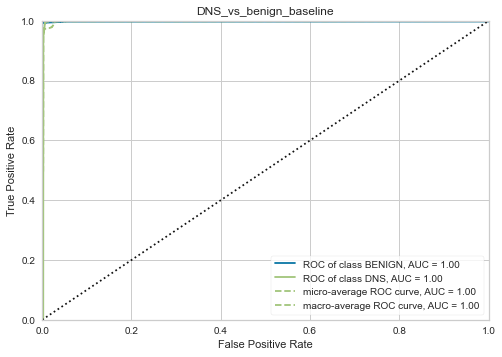

C:\ProgramData\Anaconda3\lib\site-packages\yellowbrick\classifier\base.py:234: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  YellowbrickWarning,


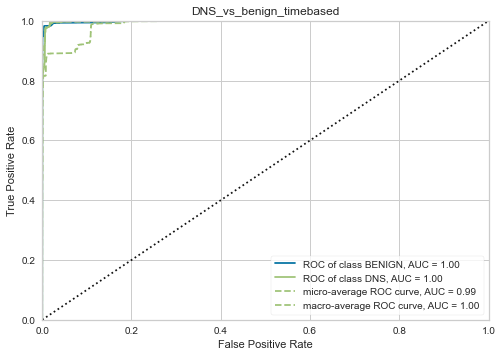

C:\ProgramData\Anaconda3\lib\site-packages\yellowbrick\classifier\base.py:234: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  YellowbrickWarning,


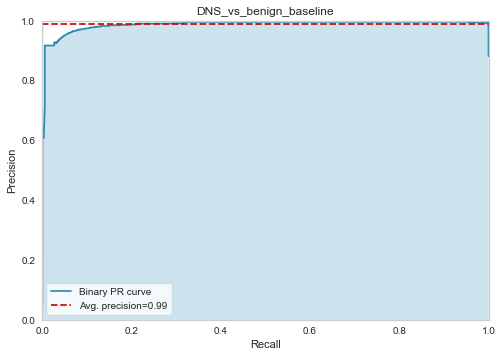

C:\ProgramData\Anaconda3\lib\site-packages\yellowbrick\classifier\base.py:234: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  YellowbrickWarning,


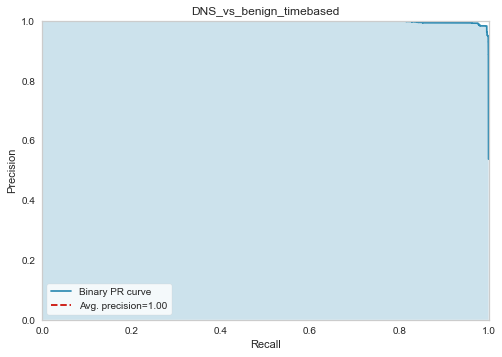

In [8]:
visualize_report(results[Baseline])
visualize_report(results[Timebased])
visualize_confusion_matrix(results[Baseline])
visualize_confusion_matrix(results[Timebased])
visualize_roc(results[Baseline])
visualize_roc(results[Timebased])
visualize_pr_curve(results[Baseline])
visualize_pr_curve(results[Timebased])

## Experiment #2: LDAP vs Benign

Loading Dataset: ../data/prepared/baseline/LDAP_vs_benign.csv
	To Dataset Cache: ../data/cache/baseline/LDAP_vs_benign.csv.pickle

Loading Dataset: ../data/prepared/timebased/LDAP_vs_benign.csv
	To Dataset Cache: ../data/cache/timebased/LDAP_vs_benign.csv.pickle

Running experiment #2:	LDAP
Baseline results
LDAP_vs_benign_baseline: (225462, 70)


epoch,train_loss,valid_loss,accuracy,time
0,0.001017,0.001010,0.999845,00:22
1,0.000920,0.001069,0.999845,00:22
2,0.000219,0.022397,0.999823,00:22
3,0.000912,0.003916,0.999823,00:22
4,0.000513,0.002309,0.999534,00:22
5,0.000495,0.001375,0.999623,00:22
6,0.000287,0.001407,0.999778,00:22
7,0.000047,0.004499,0.999645,00:22
8,0.000129,0.074146,0.998048,00:22
9,0.000064,0.031906,0.999667,00:22


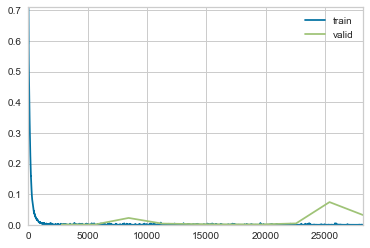

loss 0.03190607950091362: accuracy: 99.97%

Time-based results
LDAP_vs_benign_timebased: (225462, 26)


epoch,train_loss,valid_loss,accuracy,time
0,0.027634,0.197523,0.967467,00:20
1,0.015309,0.147296,0.970394,00:20
2,0.017178,0.039807,0.972345,00:20
3,0.006200,0.083444,0.971347,00:20
4,0.012911,0.155066,0.971015,00:20
5,0.005775,0.112082,0.971325,00:20
6,0.006581,0.061572,0.971858,00:20
7,0.005784,0.077219,0.971702,00:20
8,0.004694,0.105664,0.971126,00:20
9,0.007478,0.080790,0.971547,00:20


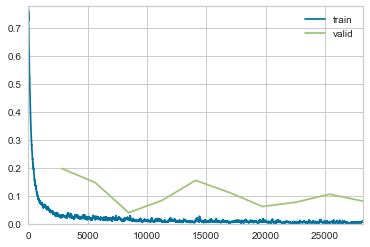

loss 0.08078955858945847: accuracy: 97.15%


In [9]:
results = next(experiment)

C:\ProgramData\Anaconda3\lib\site-packages\yellowbrick\classifier\base.py:234: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  YellowbrickWarning,


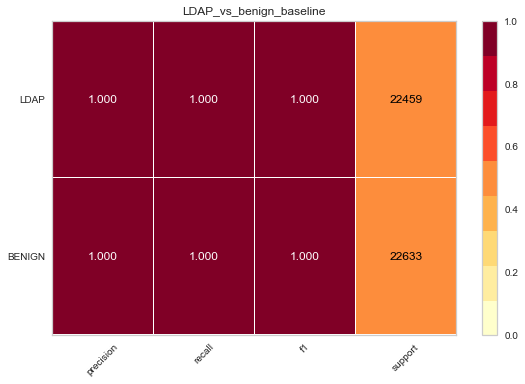

C:\ProgramData\Anaconda3\lib\site-packages\yellowbrick\classifier\base.py:234: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  YellowbrickWarning,


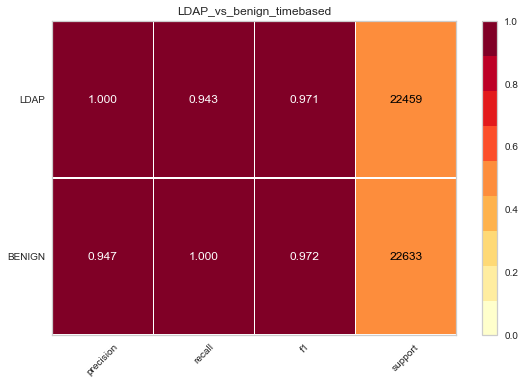

C:\ProgramData\Anaconda3\lib\site-packages\yellowbrick\classifier\base.py:234: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  YellowbrickWarning,


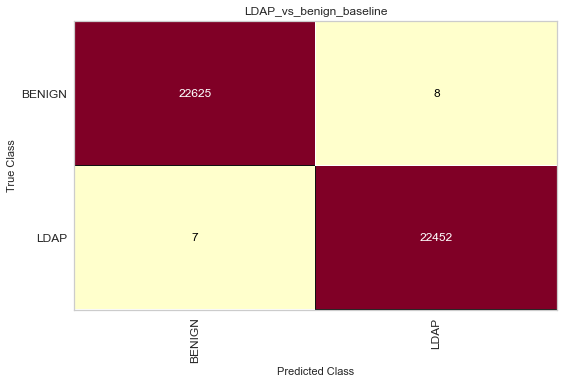

C:\ProgramData\Anaconda3\lib\site-packages\yellowbrick\classifier\base.py:234: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  YellowbrickWarning,


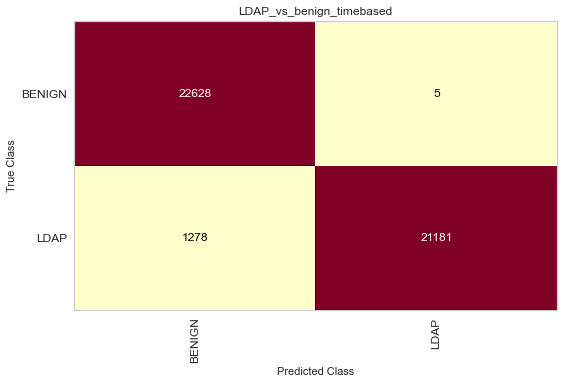

C:\ProgramData\Anaconda3\lib\site-packages\yellowbrick\classifier\base.py:234: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  YellowbrickWarning,


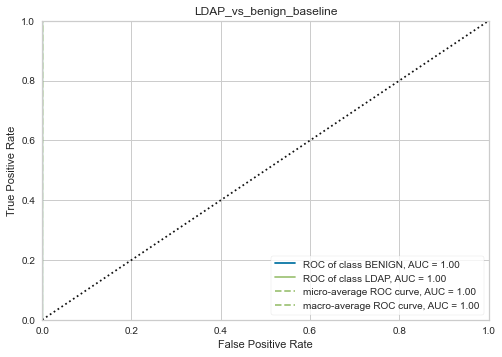

C:\ProgramData\Anaconda3\lib\site-packages\yellowbrick\classifier\base.py:234: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  YellowbrickWarning,


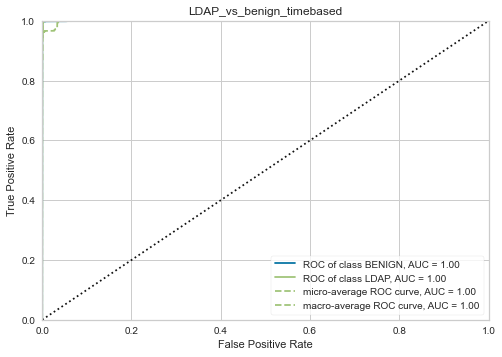

C:\ProgramData\Anaconda3\lib\site-packages\yellowbrick\classifier\base.py:234: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  YellowbrickWarning,


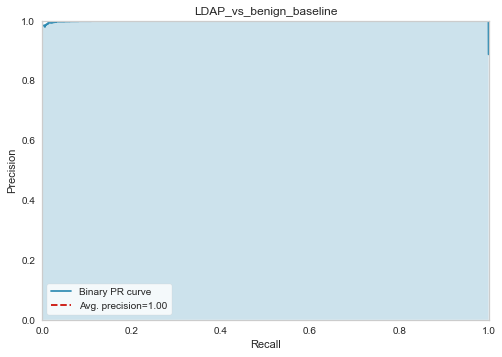

C:\ProgramData\Anaconda3\lib\site-packages\yellowbrick\classifier\base.py:234: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  YellowbrickWarning,


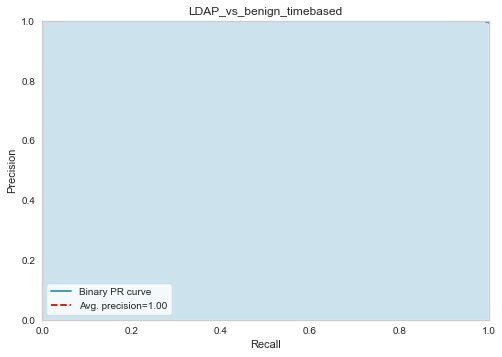

In [10]:
visualize_report(results[Baseline])
visualize_report(results[Timebased])
visualize_confusion_matrix(results[Baseline])
visualize_confusion_matrix(results[Timebased])
visualize_roc(results[Baseline])
visualize_roc(results[Timebased])
visualize_pr_curve(results[Baseline])
visualize_pr_curve(results[Timebased])

## Experiment #3: MSSQL vs Benign

Loading Dataset: ../data/prepared/baseline/MSSQL_vs_benign.csv
	To Dataset Cache: ../data/cache/baseline/MSSQL_vs_benign.csv.pickle

Loading Dataset: ../data/prepared/timebased/MSSQL_vs_benign.csv
	To Dataset Cache: ../data/cache/timebased/MSSQL_vs_benign.csv.pickle

Running experiment #3:	MSSQL
Baseline results
MSSQL_vs_benign_baseline: (225462, 70)


epoch,train_loss,valid_loss,accuracy,time
0,0.002679,0.000835,0.999911,00:22
1,0.000088,0.000671,0.999911,00:22
2,0.008751,0.000714,0.999911,00:22
3,0.000360,0.002024,0.999579,00:22
4,0.000509,0.000868,0.999845,00:22
5,0.000971,0.000767,0.999911,00:23
6,0.002955,0.003232,0.999579,00:24
7,0.000020,0.000737,0.999911,00:23
8,0.000018,0.002038,0.999778,00:24
9,0.000133,0.002112,0.999845,00:22


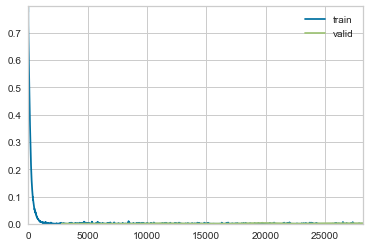

loss 0.0021123087499290705: accuracy: 99.98%

Time-based results
MSSQL_vs_benign_timebased: (225462, 26)


epoch,train_loss,valid_loss,accuracy,time
0,0.041283,0.150357,0.945689,00:21
1,0.035989,0.201284,0.937683,00:23
2,0.032598,0.310172,0.947396,00:22
3,0.029308,0.282485,0.947241,00:22
4,0.019763,0.237091,0.946820,00:25
5,0.024068,0.318124,0.946376,00:24
6,0.019093,0.169243,0.947152,00:22
7,0.009206,1.064266,0.945134,00:22
8,0.019684,0.202096,0.947108,00:22
9,0.017854,0.223847,0.946820,00:22


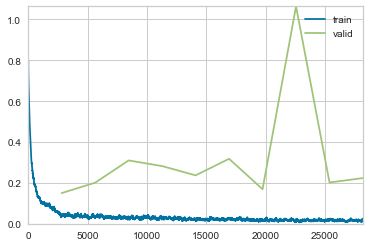

loss 0.22384747862815857: accuracy: 94.68%


In [11]:
results = next(experiment)

C:\ProgramData\Anaconda3\lib\site-packages\yellowbrick\classifier\base.py:234: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  YellowbrickWarning,


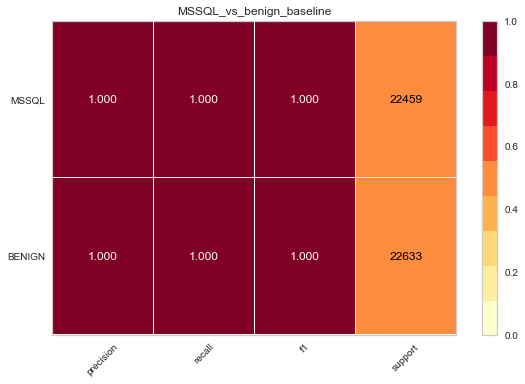

C:\ProgramData\Anaconda3\lib\site-packages\yellowbrick\classifier\base.py:234: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  YellowbrickWarning,


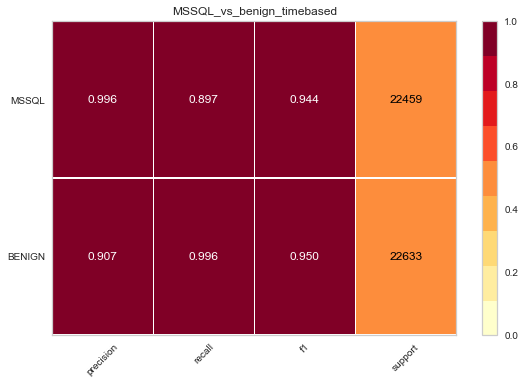

C:\ProgramData\Anaconda3\lib\site-packages\yellowbrick\classifier\base.py:234: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  YellowbrickWarning,


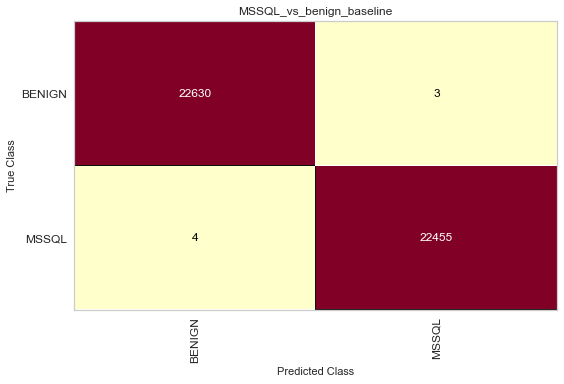

C:\ProgramData\Anaconda3\lib\site-packages\yellowbrick\classifier\base.py:234: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  YellowbrickWarning,


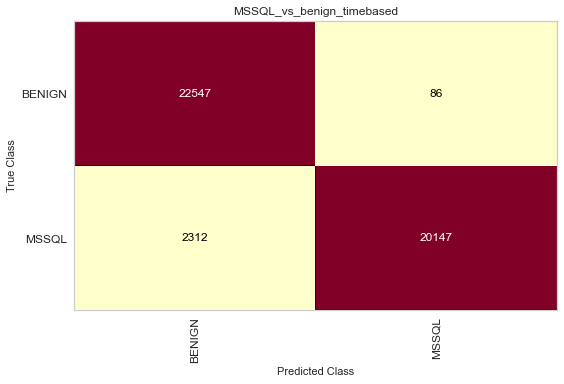

C:\ProgramData\Anaconda3\lib\site-packages\yellowbrick\classifier\base.py:234: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  YellowbrickWarning,


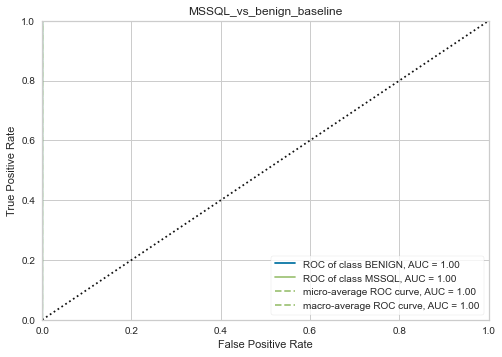

C:\ProgramData\Anaconda3\lib\site-packages\yellowbrick\classifier\base.py:234: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  YellowbrickWarning,


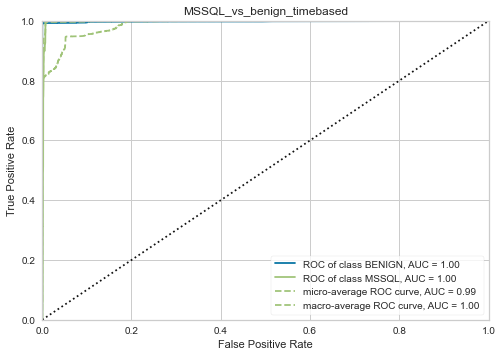

C:\ProgramData\Anaconda3\lib\site-packages\yellowbrick\classifier\base.py:234: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  YellowbrickWarning,


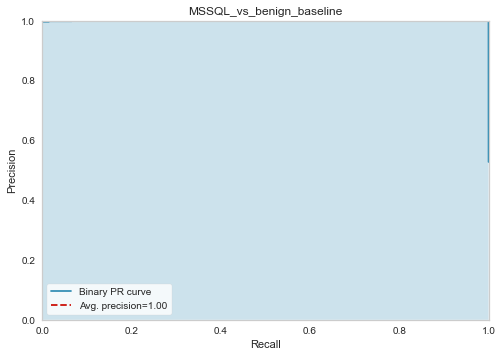

C:\ProgramData\Anaconda3\lib\site-packages\yellowbrick\classifier\base.py:234: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  YellowbrickWarning,


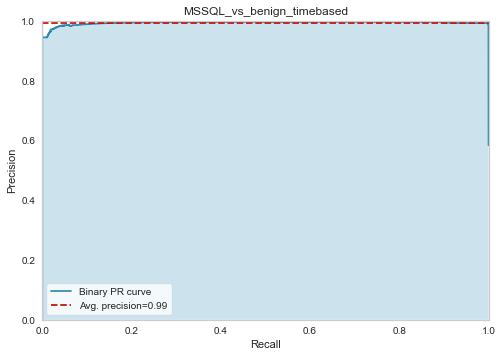

In [12]:
visualize_report(results[Baseline])
visualize_report(results[Timebased])
visualize_confusion_matrix(results[Baseline])
visualize_confusion_matrix(results[Timebased])
visualize_roc(results[Baseline])
visualize_roc(results[Timebased])
visualize_pr_curve(results[Baseline])
visualize_pr_curve(results[Timebased])

## Experiment #4: NetBIOS vs Benign

Loading Dataset: ../data/prepared/baseline/NetBIOS_vs_benign.csv
	To Dataset Cache: ../data/cache/baseline/NetBIOS_vs_benign.csv.pickle

Loading Dataset: ../data/prepared/timebased/NetBIOS_vs_benign.csv
	To Dataset Cache: ../data/cache/timebased/NetBIOS_vs_benign.csv.pickle

Running experiment #4:	NetBIOS
Baseline results
NetBIOS_vs_benign_baseline: (225462, 70)


epoch,train_loss,valid_loss,accuracy,time
0,0.001271,0.002909,0.999335,00:24
1,0.001227,0.129327,0.998137,00:26
2,0.001625,0.086726,0.999313,00:26
3,0.000901,0.020891,0.999579,00:25
4,0.000345,0.585666,0.998381,00:25
5,0.001030,0.362112,0.998470,00:26
6,0.000495,0.132050,0.999601,00:26
7,0.001194,0.558315,0.998448,00:24
8,0.000968,0.248127,0.999290,00:25
9,0.000779,0.300480,0.999401,00:25


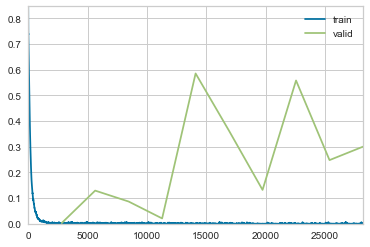

loss 0.3004799783229828: accuracy: 99.94%

Time-based results
NetBIOS_vs_benign_timebased: (225462, 26)


epoch,train_loss,valid_loss,accuracy,time
0,0.043272,0.377980,0.911692,00:25
1,0.038318,0.205393,0.913510,00:22
2,0.039421,0.277059,0.914264,00:23
3,0.033434,0.229152,0.912601,00:27
4,0.022555,0.123571,0.912180,00:23
5,0.019319,0.264165,0.911093,00:26
6,0.017142,0.084036,0.995254,00:24
7,0.030742,0.197098,0.912246,00:24
8,0.010262,0.158131,0.912224,00:23
9,0.009612,0.465810,0.912268,00:24


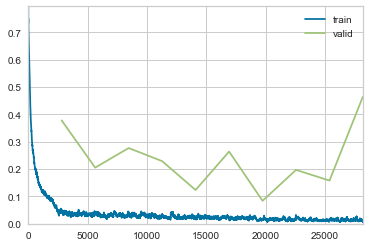

loss 0.46581047773361206: accuracy: 91.23%


In [13]:
results = next(experiment)

C:\ProgramData\Anaconda3\lib\site-packages\yellowbrick\classifier\base.py:234: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  YellowbrickWarning,


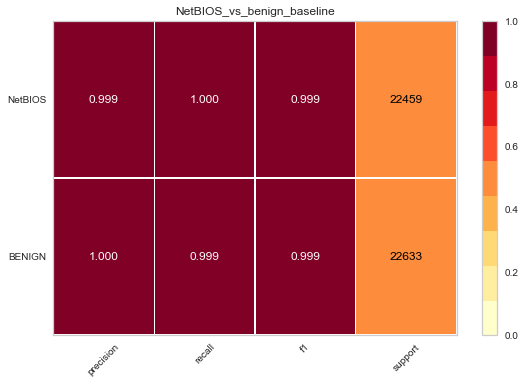

C:\ProgramData\Anaconda3\lib\site-packages\yellowbrick\classifier\base.py:234: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  YellowbrickWarning,


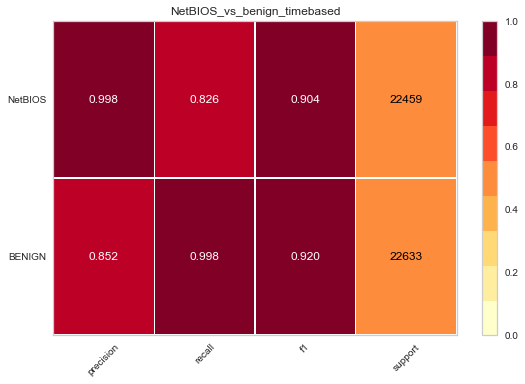

C:\ProgramData\Anaconda3\lib\site-packages\yellowbrick\classifier\base.py:234: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  YellowbrickWarning,


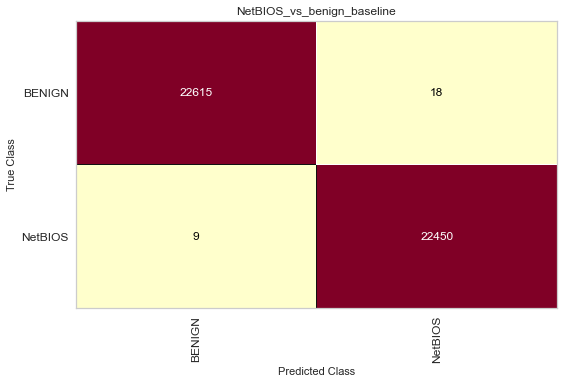

C:\ProgramData\Anaconda3\lib\site-packages\yellowbrick\classifier\base.py:234: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  YellowbrickWarning,


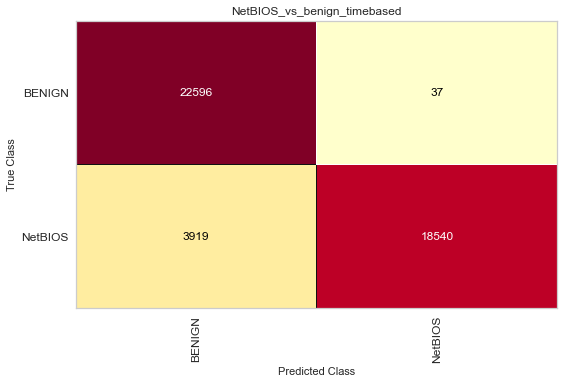

C:\ProgramData\Anaconda3\lib\site-packages\yellowbrick\classifier\base.py:234: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  YellowbrickWarning,


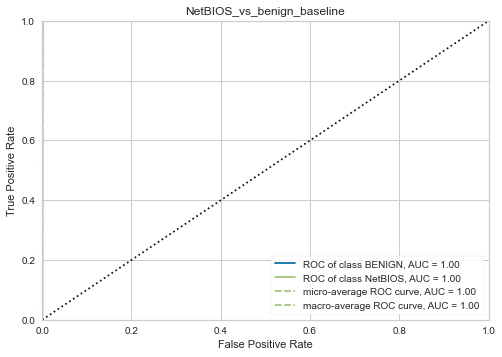

C:\ProgramData\Anaconda3\lib\site-packages\yellowbrick\classifier\base.py:234: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  YellowbrickWarning,


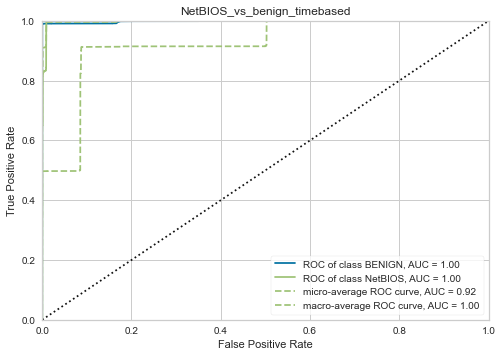

C:\ProgramData\Anaconda3\lib\site-packages\yellowbrick\classifier\base.py:234: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  YellowbrickWarning,


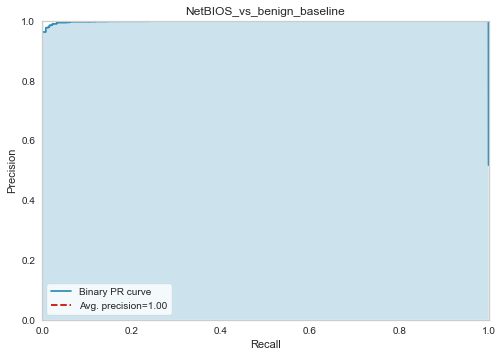

C:\ProgramData\Anaconda3\lib\site-packages\yellowbrick\classifier\base.py:234: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  YellowbrickWarning,


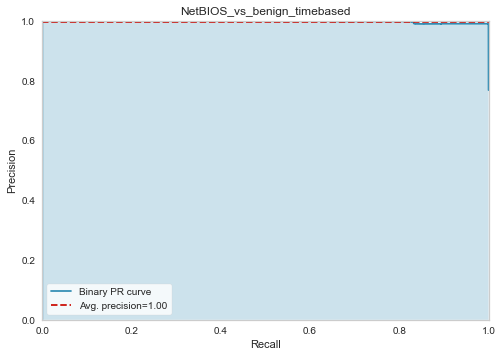

In [14]:
visualize_report(results[Baseline])
visualize_report(results[Timebased])
visualize_confusion_matrix(results[Baseline])
visualize_confusion_matrix(results[Timebased])
visualize_roc(results[Baseline])
visualize_roc(results[Timebased])
visualize_pr_curve(results[Baseline])
visualize_pr_curve(results[Timebased])

## Experiment #5: NTP vs Benign

Loading Dataset: ../data/prepared/baseline/NTP_vs_benign.csv
	To Dataset Cache: ../data/cache/baseline/NTP_vs_benign.csv.pickle

Loading Dataset: ../data/prepared/timebased/NTP_vs_benign.csv
	To Dataset Cache: ../data/cache/timebased/NTP_vs_benign.csv.pickle

Running experiment #5:	NTP
Baseline results
NTP_vs_benign_baseline: (225462, 70)


epoch,train_loss,valid_loss,accuracy,time
0,0.010331,0.122997,0.996186,00:25
1,0.011060,0.012170,0.997694,00:24
2,0.005485,0.007449,0.998337,00:27
3,0.004878,0.016517,0.997538,00:26
4,0.007074,0.008312,0.998337,00:24
5,0.007106,0.017470,0.997206,00:24
6,0.006024,0.006585,0.998692,00:26
7,0.005007,0.006311,0.998470,00:30
8,0.003608,0.006151,0.998669,00:27
9,0.004404,0.006416,0.998647,00:28


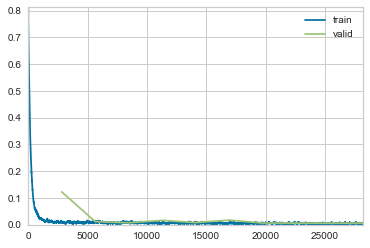

loss 0.006415761075913906: accuracy: 99.86%

Time-based results
NTP_vs_benign_timebased: (225462, 26)


epoch,train_loss,valid_loss,accuracy,time
0,0.104566,0.233095,0.887497,00:22
1,0.088121,0.330978,0.810188,00:23
2,0.071673,0.210926,0.971458,00:24
3,0.070031,0.185580,0.962920,00:23
4,0.061064,0.278854,0.843143,00:24
5,0.065427,0.277619,0.880999,00:25
6,0.053559,0.316312,0.965471,00:23
7,0.058464,0.212340,0.943715,00:22
8,0.062403,0.190711,0.961567,00:23
9,0.047720,0.605895,0.691298,00:24


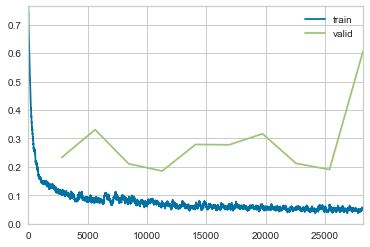

loss 0.6058950424194336: accuracy: 69.13%


In [15]:
results = next(experiment)

C:\ProgramData\Anaconda3\lib\site-packages\yellowbrick\classifier\base.py:234: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  YellowbrickWarning,


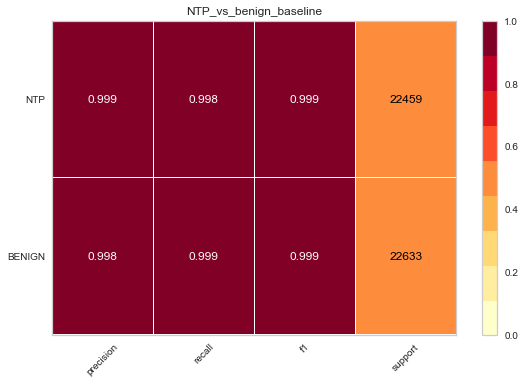

C:\ProgramData\Anaconda3\lib\site-packages\yellowbrick\classifier\base.py:234: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  YellowbrickWarning,


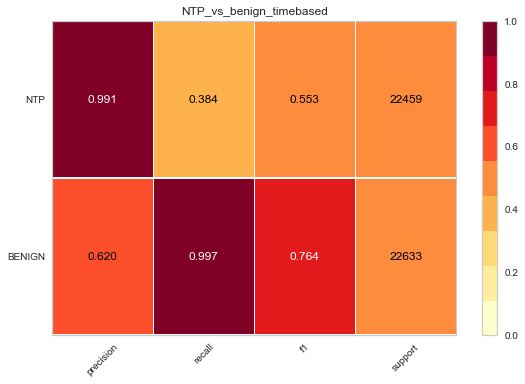

C:\ProgramData\Anaconda3\lib\site-packages\yellowbrick\classifier\base.py:234: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  YellowbrickWarning,


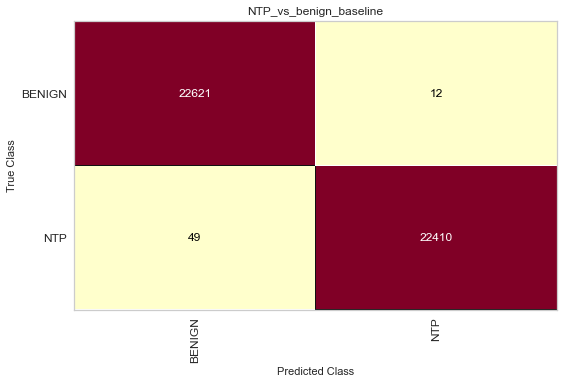

C:\ProgramData\Anaconda3\lib\site-packages\yellowbrick\classifier\base.py:234: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  YellowbrickWarning,


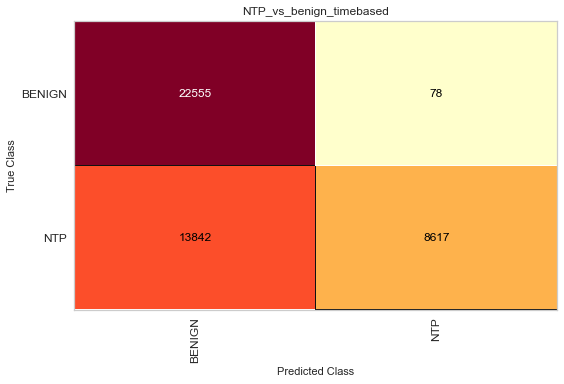

C:\ProgramData\Anaconda3\lib\site-packages\yellowbrick\classifier\base.py:234: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  YellowbrickWarning,


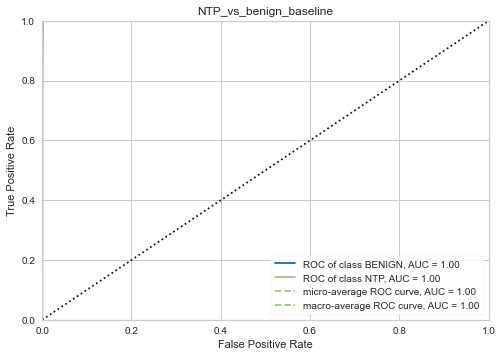

C:\ProgramData\Anaconda3\lib\site-packages\yellowbrick\classifier\base.py:234: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  YellowbrickWarning,


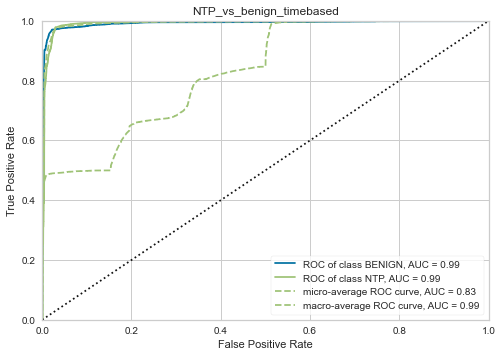

C:\ProgramData\Anaconda3\lib\site-packages\yellowbrick\classifier\base.py:234: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  YellowbrickWarning,


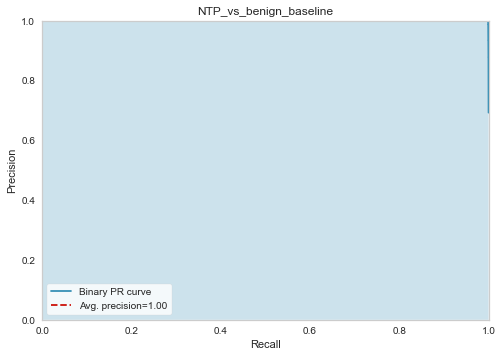

C:\ProgramData\Anaconda3\lib\site-packages\yellowbrick\classifier\base.py:234: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  YellowbrickWarning,


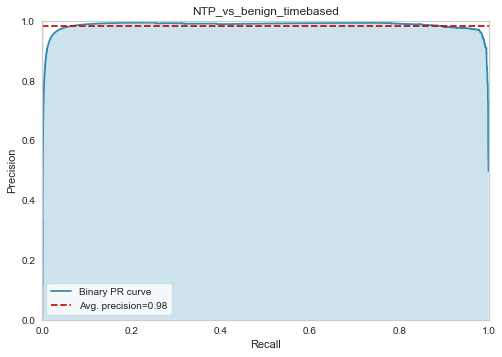

In [16]:
visualize_report(results[Baseline])
visualize_report(results[Timebased])
visualize_confusion_matrix(results[Baseline])
visualize_confusion_matrix(results[Timebased])
visualize_roc(results[Baseline])
visualize_roc(results[Timebased])
visualize_pr_curve(results[Baseline])
visualize_pr_curve(results[Timebased])

## Experiment #6: Portmap vs Benign

Loading Dataset: ../data/prepared/baseline/Portmap_vs_benign.csv
	To Dataset Cache: ../data/cache/baseline/Portmap_vs_benign.csv.pickle

Loading Dataset: ../data/prepared/timebased/Portmap_vs_benign.csv
	To Dataset Cache: ../data/cache/timebased/Portmap_vs_benign.csv.pickle

Running experiment #6:	Portmap
Baseline results
Portmap_vs_benign_baseline: (225462, 70)


epoch,train_loss,valid_loss,accuracy,time
0,0.007494,0.011966,0.999069,00:24
1,0.004703,0.076521,0.997960,00:23
2,0.002639,0.282431,0.998980,00:24
3,0.003307,0.269467,0.998425,00:24
4,0.005340,0.370905,0.998381,00:24
5,0.001512,0.394519,0.996673,00:25
6,0.005267,0.870084,0.994500,00:24
7,0.003143,0.268191,0.997960,00:24
8,0.002415,0.545222,0.996119,00:23
9,0.005642,0.405720,0.997627,00:26


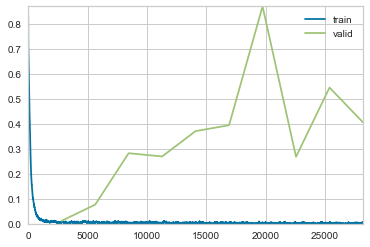

loss 0.40571969747543335: accuracy: 99.76%

Time-based results
Portmap_vs_benign_timebased: (225462, 26)


epoch,train_loss,valid_loss,accuracy,time
0,0.050171,0.184120,0.932183,00:25
1,0.037196,0.286136,0.930875,00:23
2,0.032605,0.227114,0.932848,00:30
3,0.033804,0.216657,0.932981,00:26
4,0.035247,0.199498,0.933536,00:22
5,0.035111,0.205299,0.931229,00:25
6,0.027210,0.179240,0.932294,00:27
7,0.016260,0.178740,0.931651,00:25
8,0.020706,0.198875,0.931606,00:24
9,0.020227,0.172632,0.931584,00:24


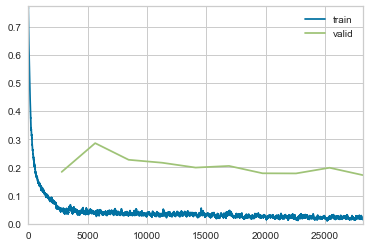

loss 0.17263208329677582: accuracy: 93.16%


In [17]:
results = next(experiment)

C:\ProgramData\Anaconda3\lib\site-packages\yellowbrick\classifier\base.py:234: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  YellowbrickWarning,


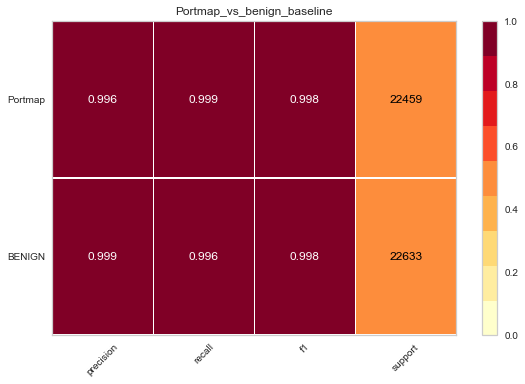

C:\ProgramData\Anaconda3\lib\site-packages\yellowbrick\classifier\base.py:234: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  YellowbrickWarning,


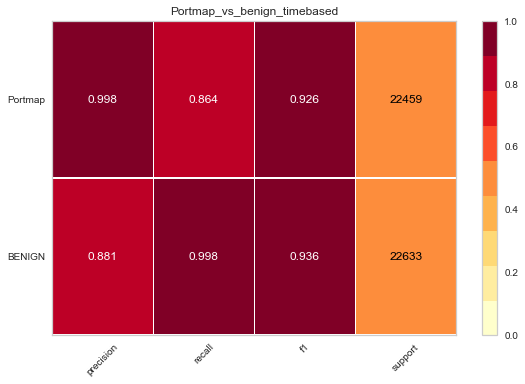

C:\ProgramData\Anaconda3\lib\site-packages\yellowbrick\classifier\base.py:234: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  YellowbrickWarning,


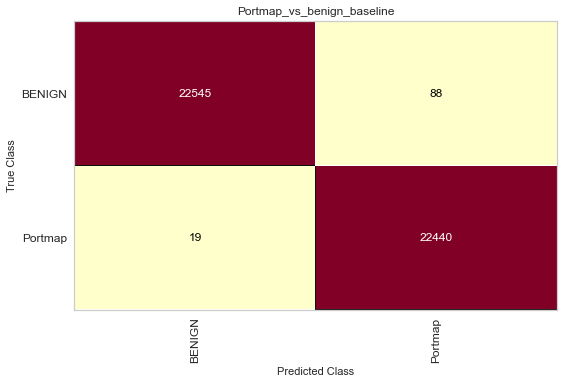

C:\ProgramData\Anaconda3\lib\site-packages\yellowbrick\classifier\base.py:234: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  YellowbrickWarning,


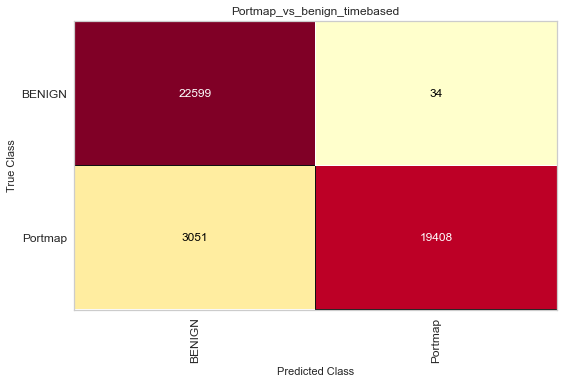

C:\ProgramData\Anaconda3\lib\site-packages\yellowbrick\classifier\base.py:234: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  YellowbrickWarning,


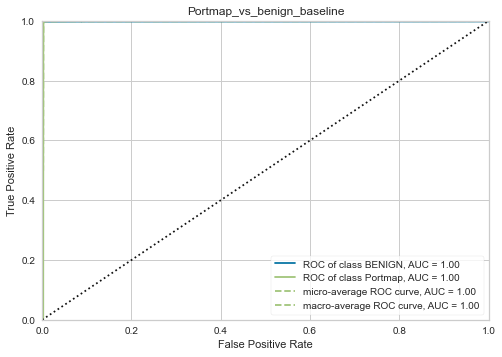

C:\ProgramData\Anaconda3\lib\site-packages\yellowbrick\classifier\base.py:234: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  YellowbrickWarning,


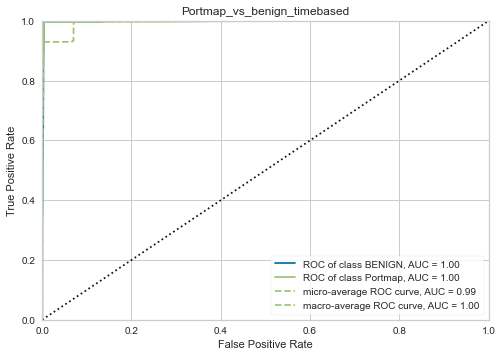

C:\ProgramData\Anaconda3\lib\site-packages\yellowbrick\classifier\base.py:234: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  YellowbrickWarning,


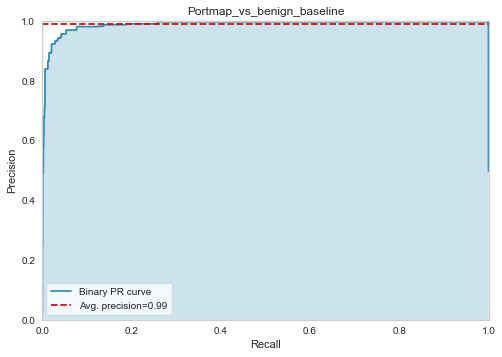

C:\ProgramData\Anaconda3\lib\site-packages\yellowbrick\classifier\base.py:234: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  YellowbrickWarning,


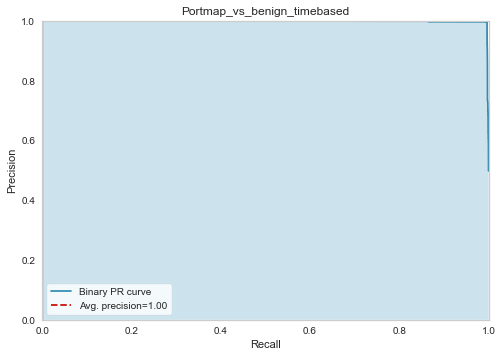

In [18]:
visualize_report(results[Baseline])
visualize_report(results[Timebased])
visualize_confusion_matrix(results[Baseline])
visualize_confusion_matrix(results[Timebased])
visualize_roc(results[Baseline])
visualize_roc(results[Timebased])
visualize_pr_curve(results[Baseline])
visualize_pr_curve(results[Timebased])

## Experiment #7: SNMP vs Benign

Loading Dataset: ../data/prepared/baseline/SNMP_vs_benign.csv
	To Dataset Cache: ../data/cache/baseline/SNMP_vs_benign.csv.pickle

Loading Dataset: ../data/prepared/timebased/SNMP_vs_benign.csv
	To Dataset Cache: ../data/cache/timebased/SNMP_vs_benign.csv.pickle

Running experiment #7:	SNMP
Baseline results
SNMP_vs_benign_baseline: (225462, 70)


epoch,train_loss,valid_loss,accuracy,time
0,0.004212,0.005647,0.998692,00:24
1,0.001755,0.003535,0.999313,00:24
2,0.003472,0.003983,0.999690,00:23
3,0.002282,0.001437,0.999800,00:23
4,0.001629,0.001342,0.999778,00:23
5,0.000265,0.054180,0.999534,00:23
6,0.002100,0.004174,0.999778,00:23
7,0.000447,0.001227,0.999800,00:23
8,0.000528,0.008802,0.999712,00:23
9,0.002668,0.021776,0.999645,00:23


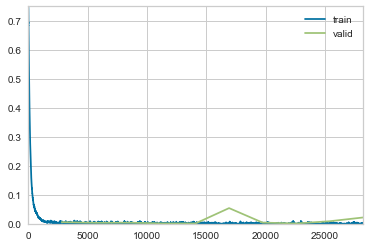

loss 0.021775593981146812: accuracy: 99.96%

Time-based results
SNMP_vs_benign_timebased: (225462, 26)


epoch,train_loss,valid_loss,accuracy,time
0,0.039844,0.070856,0.983811,00:21
1,0.015789,0.082958,0.986250,00:21
2,0.015855,0.055725,0.986672,00:21
3,0.021340,0.102841,0.985430,00:22
4,0.013880,0.087693,0.985940,00:21
5,0.012468,0.078551,0.986295,00:21
6,0.011807,0.093264,0.984232,00:21
7,0.009567,0.069196,0.986095,00:21
8,0.015479,0.053787,0.986361,00:21
9,0.008172,0.056038,0.986406,00:21


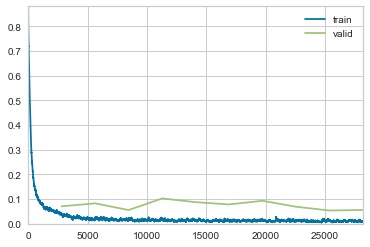

loss 0.056038226932287216: accuracy: 98.64%


In [19]:
results = next(experiment)

C:\ProgramData\Anaconda3\lib\site-packages\yellowbrick\classifier\base.py:234: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  YellowbrickWarning,


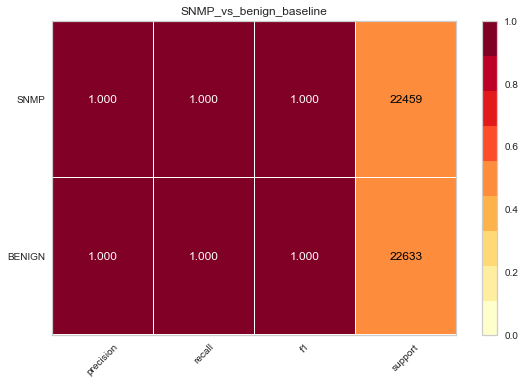

C:\ProgramData\Anaconda3\lib\site-packages\yellowbrick\classifier\base.py:234: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  YellowbrickWarning,


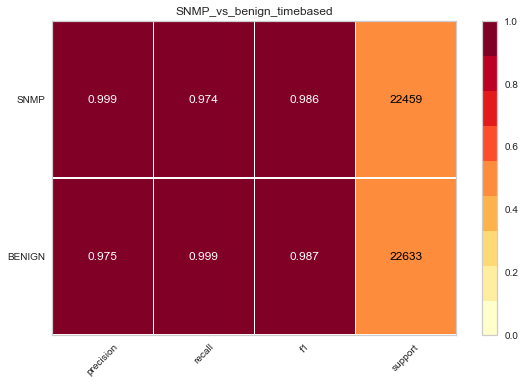

C:\ProgramData\Anaconda3\lib\site-packages\yellowbrick\classifier\base.py:234: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  YellowbrickWarning,


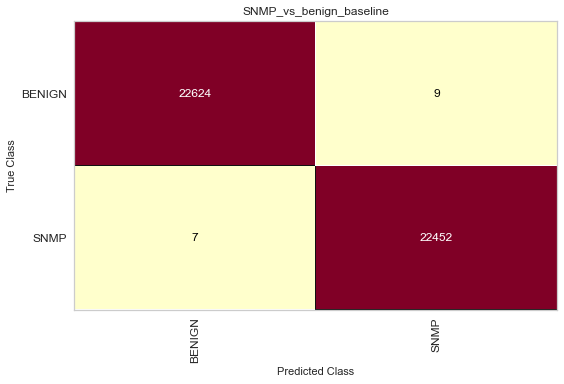

C:\ProgramData\Anaconda3\lib\site-packages\yellowbrick\classifier\base.py:234: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  YellowbrickWarning,


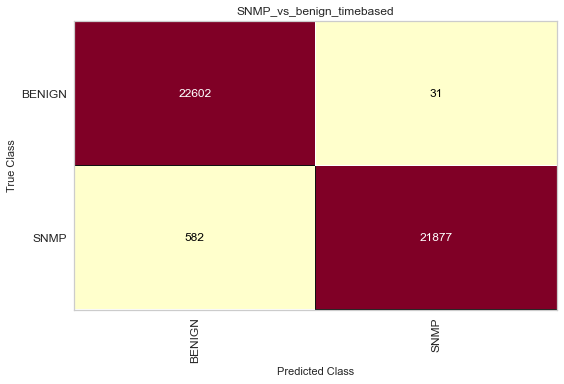

C:\ProgramData\Anaconda3\lib\site-packages\yellowbrick\classifier\base.py:234: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  YellowbrickWarning,


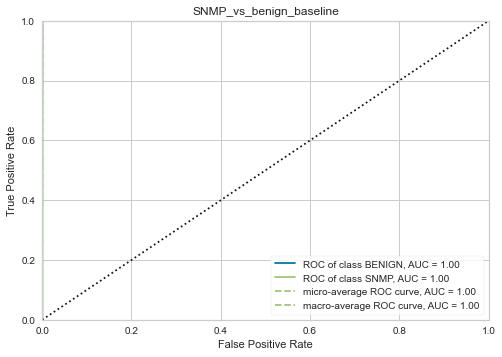

C:\ProgramData\Anaconda3\lib\site-packages\yellowbrick\classifier\base.py:234: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  YellowbrickWarning,


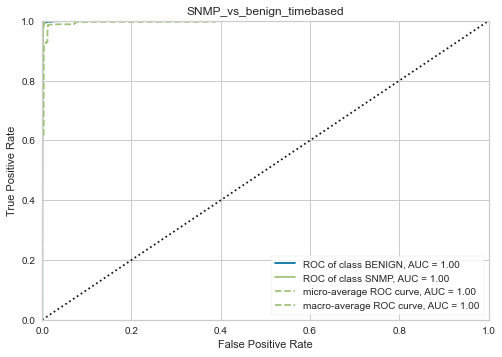

C:\ProgramData\Anaconda3\lib\site-packages\yellowbrick\classifier\base.py:234: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  YellowbrickWarning,


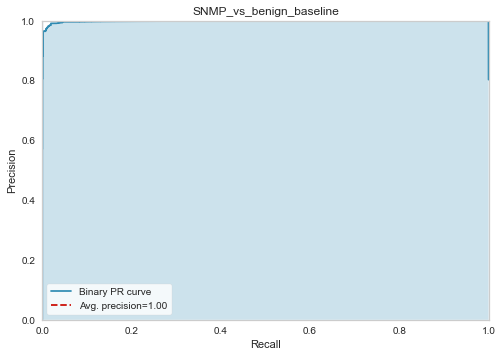

C:\ProgramData\Anaconda3\lib\site-packages\yellowbrick\classifier\base.py:234: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  YellowbrickWarning,


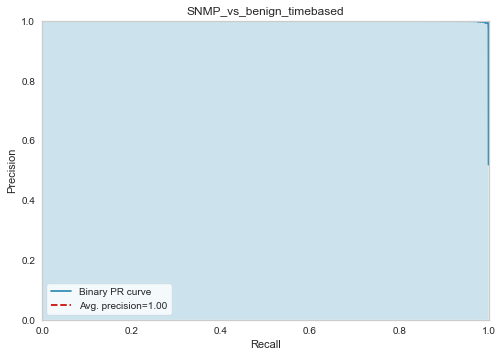

In [20]:
visualize_report(results[Baseline])
visualize_report(results[Timebased])
visualize_confusion_matrix(results[Baseline])
visualize_confusion_matrix(results[Timebased])
visualize_roc(results[Baseline])
visualize_roc(results[Timebased])
visualize_pr_curve(results[Baseline])
visualize_pr_curve(results[Timebased])

## Experiment #8: SSDP vs Benign

Loading Dataset: ../data/prepared/baseline/SSDP_vs_benign.csv
	To Dataset Cache: ../data/cache/baseline/SSDP_vs_benign.csv.pickle

Loading Dataset: ../data/prepared/timebased/SSDP_vs_benign.csv
	To Dataset Cache: ../data/cache/timebased/SSDP_vs_benign.csv.pickle

Running experiment #8:	SSDP
Baseline results
SSDP_vs_benign_baseline: (225462, 70)


epoch,train_loss,valid_loss,accuracy,time
0,0.002111,0.000950,0.999889,00:24
1,0.000374,0.000650,0.999889,00:24
2,0.000343,0.062380,0.999845,00:23
3,0.003571,0.051380,0.999556,00:23
4,0.000614,0.116399,0.999845,00:23
5,0.000056,0.116096,0.999845,00:23
6,0.000145,0.119040,0.999867,00:23
7,0.000161,0.088337,0.999867,00:23
8,0.000207,0.132058,0.999823,00:23
9,0.000129,0.087861,0.999867,00:25


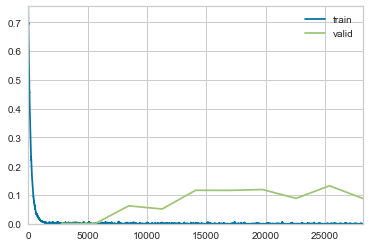

loss 0.08786074072122574: accuracy: 99.99%

Time-based results
SSDP_vs_benign_timebased: (225462, 26)


epoch,train_loss,valid_loss,accuracy,time
0,0.086194,0.442745,0.720394,00:22
1,0.068668,1.497129,0.720704,00:21
2,0.046004,0.701450,0.722612,00:21
3,0.050351,0.762942,0.723454,00:21
4,0.044003,0.471819,0.723499,00:21
5,0.045724,2.122986,0.711989,00:21
6,0.038790,0.927056,0.721525,00:22
7,0.029409,1.142610,0.719485,00:21
8,0.026856,1.093046,0.713940,00:22
9,0.028945,2.556340,0.692274,00:22


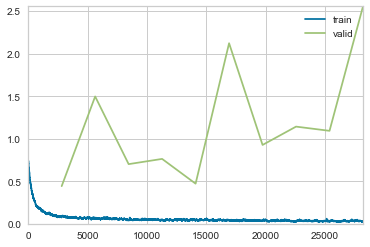

loss 2.556339740753174: accuracy: 69.23%


In [21]:
results = next(experiment)

C:\ProgramData\Anaconda3\lib\site-packages\yellowbrick\classifier\base.py:234: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  YellowbrickWarning,


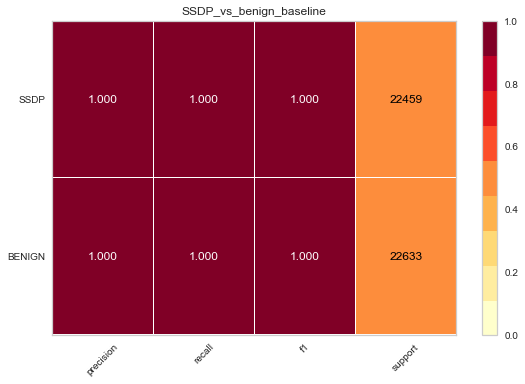

C:\ProgramData\Anaconda3\lib\site-packages\yellowbrick\classifier\base.py:234: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  YellowbrickWarning,


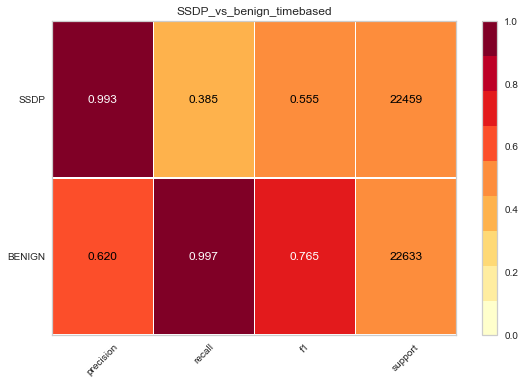

C:\ProgramData\Anaconda3\lib\site-packages\yellowbrick\classifier\base.py:234: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  YellowbrickWarning,


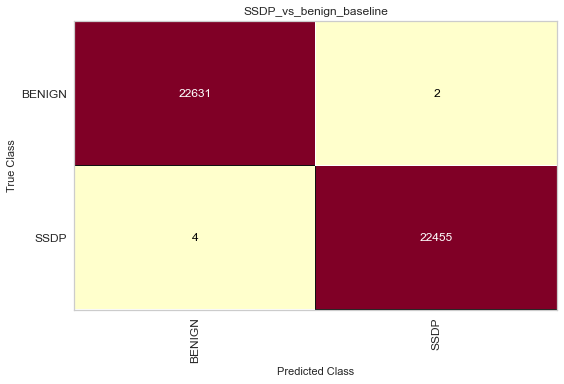

C:\ProgramData\Anaconda3\lib\site-packages\yellowbrick\classifier\base.py:234: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  YellowbrickWarning,


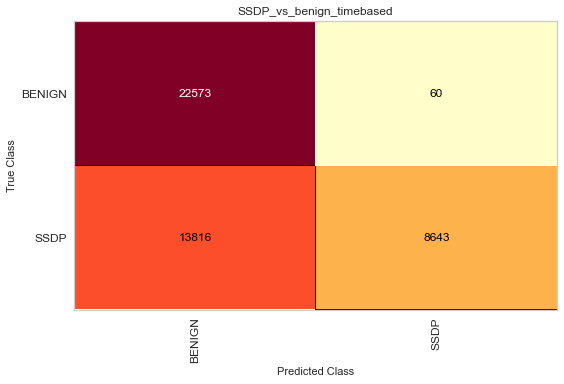

C:\ProgramData\Anaconda3\lib\site-packages\yellowbrick\classifier\base.py:234: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  YellowbrickWarning,


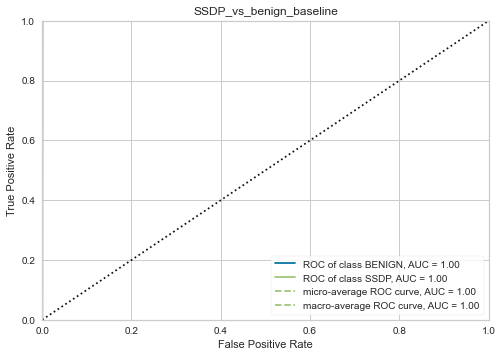

C:\ProgramData\Anaconda3\lib\site-packages\yellowbrick\classifier\base.py:234: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  YellowbrickWarning,


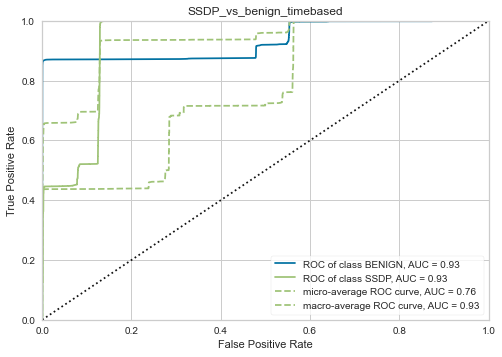

C:\ProgramData\Anaconda3\lib\site-packages\yellowbrick\classifier\base.py:234: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  YellowbrickWarning,


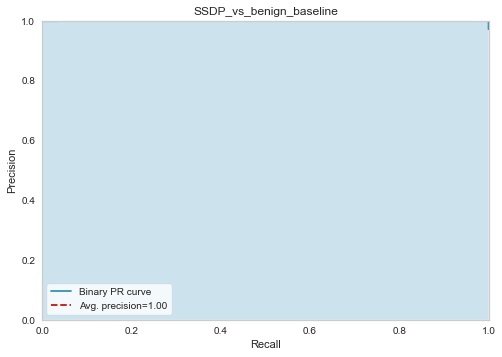

C:\ProgramData\Anaconda3\lib\site-packages\yellowbrick\classifier\base.py:234: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  YellowbrickWarning,


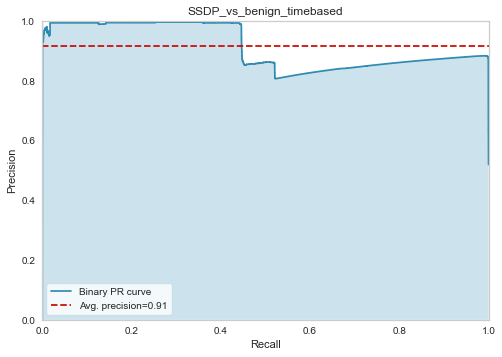

In [22]:
visualize_report(results[Baseline])
visualize_report(results[Timebased])
visualize_confusion_matrix(results[Baseline])
visualize_confusion_matrix(results[Timebased])
visualize_roc(results[Baseline])
visualize_roc(results[Timebased])
visualize_pr_curve(results[Baseline])
visualize_pr_curve(results[Timebased])

## Experiment #9: Syn vs Benign

Loading Dataset: ../data/prepared/baseline/Syn_vs_benign.csv
	To Dataset Cache: ../data/cache/baseline/Syn_vs_benign.csv.pickle

Loading Dataset: ../data/prepared/timebased/Syn_vs_benign.csv
	To Dataset Cache: ../data/cache/timebased/Syn_vs_benign.csv.pickle

Running experiment #9:	Syn
Baseline results
Syn_vs_benign_baseline: (225462, 70)


epoch,train_loss,valid_loss,accuracy,time
0,0.009229,0.014318,0.998115,00:23
1,0.003437,0.062589,0.997671,00:23
2,0.001927,0.012230,0.998603,00:23
3,0.003938,0.044419,0.998448,00:23
4,0.003088,0.013401,0.998869,00:23
5,0.001914,0.097485,0.998492,00:23
6,0.000905,0.134624,0.998758,00:23
7,0.000326,0.020252,0.999179,00:23
8,0.002152,0.331167,0.998492,00:23
9,0.000315,0.188679,0.998536,00:23


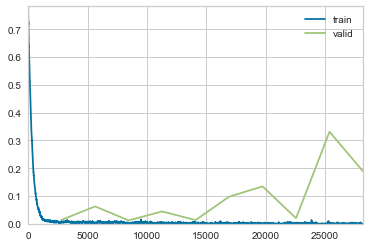

loss 0.18867871165275574: accuracy: 99.85%

Time-based results
Syn_vs_benign_timebased: (225462, 26)


epoch,train_loss,valid_loss,accuracy,time
0,0.366726,0.441377,0.765990,00:21
1,0.224053,0.324348,0.846935,00:21
2,0.205862,0.265413,0.908055,00:23
3,0.194456,0.327224,0.813670,00:22
4,0.170853,0.311277,0.913333,00:22
5,0.167480,0.614886,0.771068,00:22
6,0.149407,0.608489,0.773751,00:21
7,0.140056,1.089310,0.773552,00:21
8,0.144993,1.374412,0.690655,00:21
9,0.142397,1.214285,0.772753,00:21


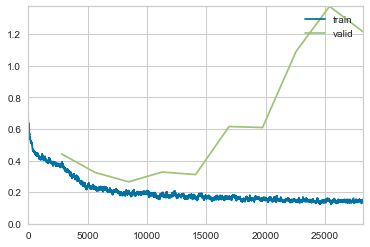

loss 1.2142847776412964: accuracy: 77.28%


In [23]:
results = next(experiment)

C:\ProgramData\Anaconda3\lib\site-packages\yellowbrick\classifier\base.py:234: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  YellowbrickWarning,


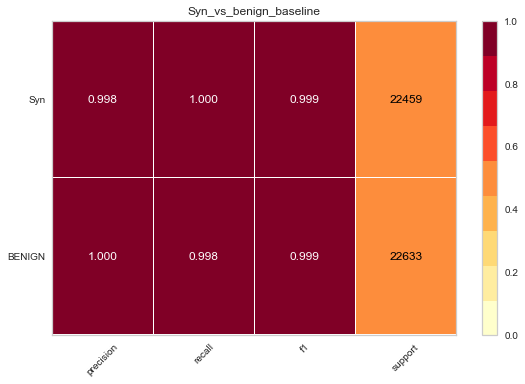

C:\ProgramData\Anaconda3\lib\site-packages\yellowbrick\classifier\base.py:234: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  YellowbrickWarning,


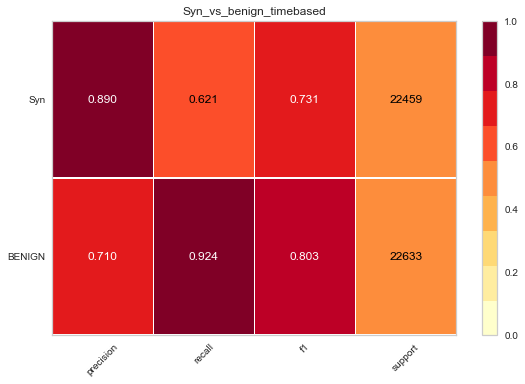

C:\ProgramData\Anaconda3\lib\site-packages\yellowbrick\classifier\base.py:234: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  YellowbrickWarning,


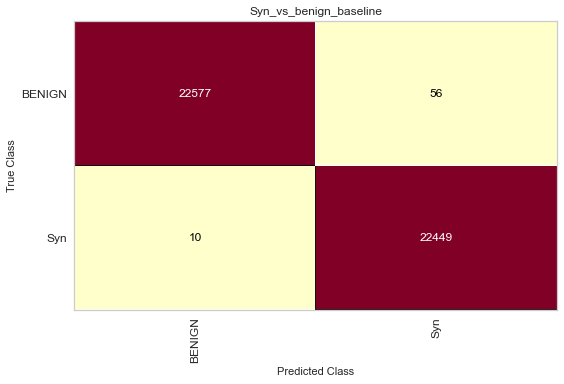

C:\ProgramData\Anaconda3\lib\site-packages\yellowbrick\classifier\base.py:234: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  YellowbrickWarning,


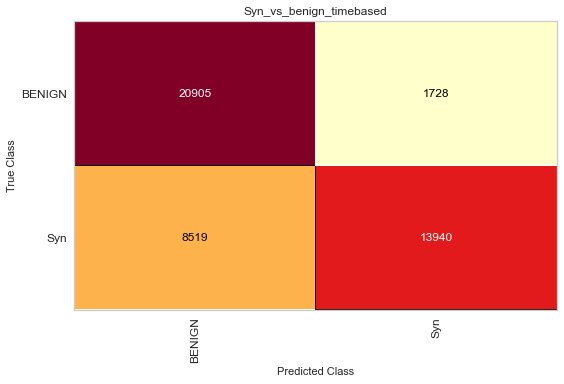

C:\ProgramData\Anaconda3\lib\site-packages\yellowbrick\classifier\base.py:234: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  YellowbrickWarning,


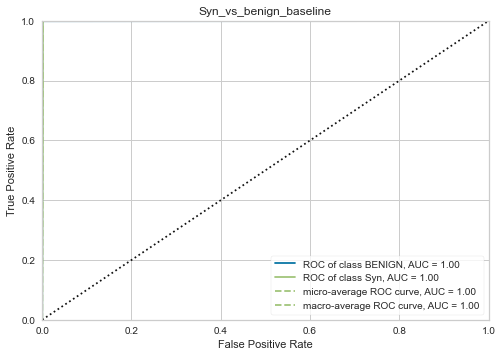

C:\ProgramData\Anaconda3\lib\site-packages\yellowbrick\classifier\base.py:234: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  YellowbrickWarning,


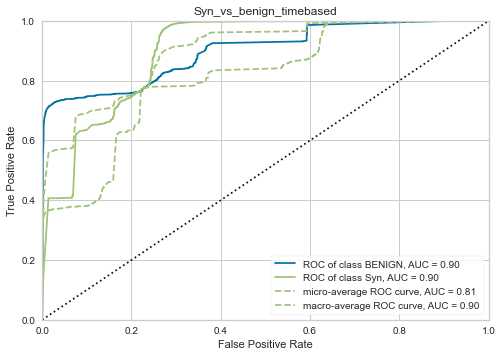

C:\ProgramData\Anaconda3\lib\site-packages\yellowbrick\classifier\base.py:234: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  YellowbrickWarning,


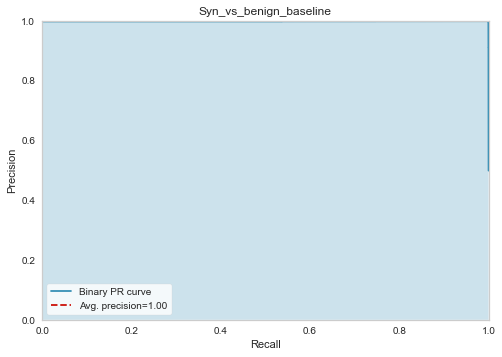

C:\ProgramData\Anaconda3\lib\site-packages\yellowbrick\classifier\base.py:234: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  YellowbrickWarning,


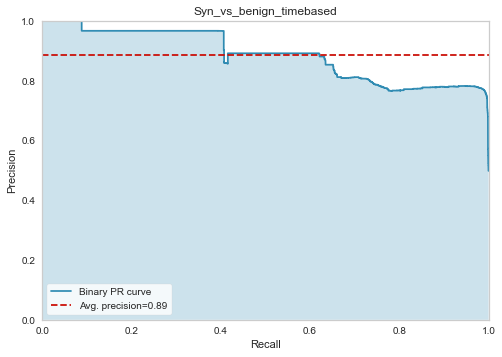

In [24]:
visualize_report(results[Baseline])
visualize_report(results[Timebased])
visualize_confusion_matrix(results[Baseline])
visualize_confusion_matrix(results[Timebased])
visualize_roc(results[Baseline])
visualize_roc(results[Timebased])
visualize_pr_curve(results[Baseline])
visualize_pr_curve(results[Timebased])

## Experiment #10: TFTP vs Benign

Loading Dataset: ../data/prepared/baseline/TFTP_vs_benign.csv
	To Dataset Cache: ../data/cache/baseline/TFTP_vs_benign.csv.pickle

Loading Dataset: ../data/prepared/timebased/TFTP_vs_benign.csv
	To Dataset Cache: ../data/cache/timebased/TFTP_vs_benign.csv.pickle

Running experiment #10:	TFTP
Baseline results
TFTP_vs_benign_baseline: (225462, 70)


epoch,train_loss,valid_loss,accuracy,time
0,0.004784,0.007835,0.998359,00:23
1,0.002492,0.003516,0.999246,00:23
2,0.004106,0.024677,0.999468,00:24
3,0.001998,0.002322,0.999446,00:23
4,0.003210,0.002793,0.999423,00:24
5,0.002904,0.002360,0.999401,00:23
6,0.001470,0.002189,0.999534,00:24
7,0.002597,0.002125,0.999579,00:23
8,0.002586,0.002134,0.999601,00:27
9,0.002910,0.002067,0.999623,00:23


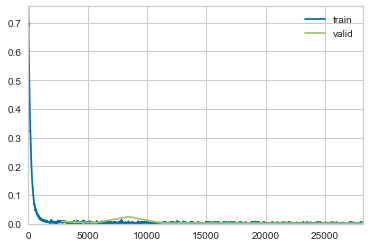

loss 0.002066645072773099: accuracy: 99.96%

Time-based results
TFTP_vs_benign_timebased: (225462, 26)


epoch,train_loss,valid_loss,accuracy,time
0,0.065301,0.135893,0.971658,00:23
1,0.047411,0.122089,0.975184,00:21
2,0.037263,0.254741,0.966735,00:22
3,0.036582,0.155460,0.973388,00:21
4,0.028722,0.077397,0.973210,00:21
5,0.027706,0.087544,0.975872,00:22
6,0.025998,0.090406,0.973233,00:21
7,0.028036,0.089873,0.973632,00:21
8,0.021116,0.082706,0.973543,00:22
9,0.020375,0.106108,0.973144,00:22


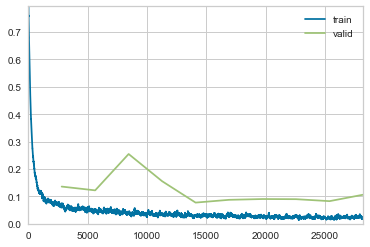

loss 0.1061079353094101: accuracy: 97.31%


In [25]:
results = next(experiment)

C:\ProgramData\Anaconda3\lib\site-packages\yellowbrick\classifier\base.py:234: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  YellowbrickWarning,


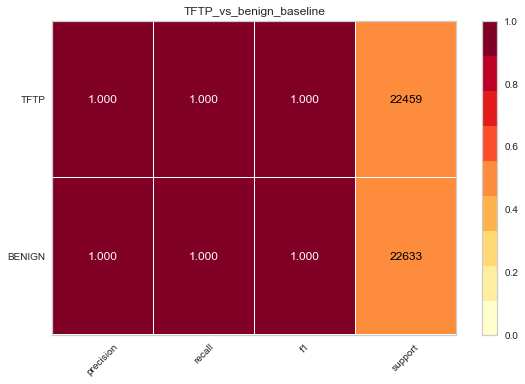

C:\ProgramData\Anaconda3\lib\site-packages\yellowbrick\classifier\base.py:234: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  YellowbrickWarning,


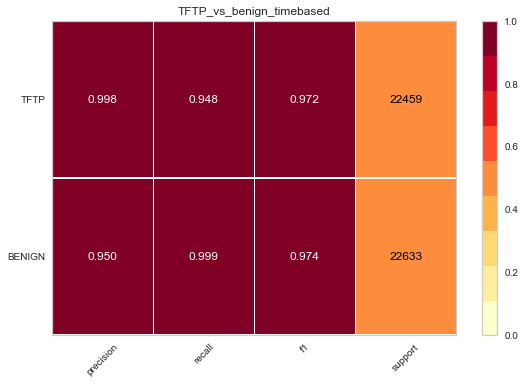

C:\ProgramData\Anaconda3\lib\site-packages\yellowbrick\classifier\base.py:234: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  YellowbrickWarning,


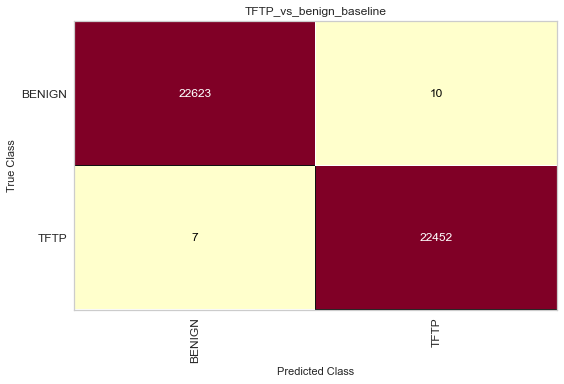

C:\ProgramData\Anaconda3\lib\site-packages\yellowbrick\classifier\base.py:234: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  YellowbrickWarning,


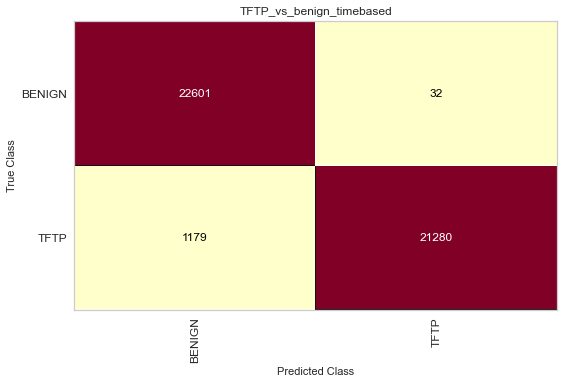

C:\ProgramData\Anaconda3\lib\site-packages\yellowbrick\classifier\base.py:234: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  YellowbrickWarning,


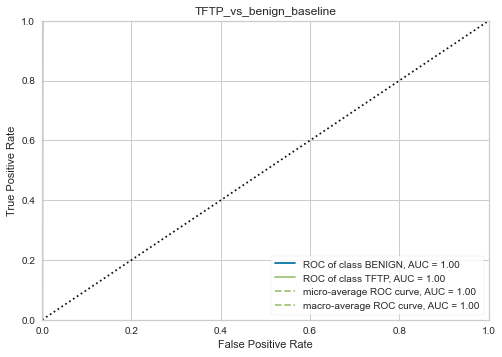

C:\ProgramData\Anaconda3\lib\site-packages\yellowbrick\classifier\base.py:234: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  YellowbrickWarning,


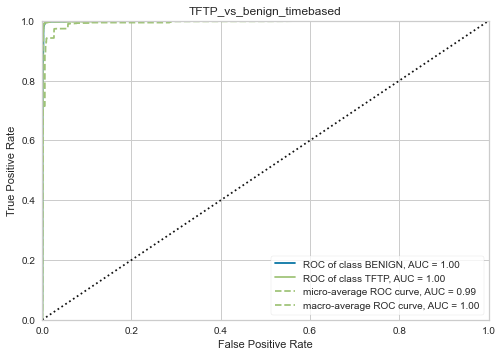

C:\ProgramData\Anaconda3\lib\site-packages\yellowbrick\classifier\base.py:234: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  YellowbrickWarning,


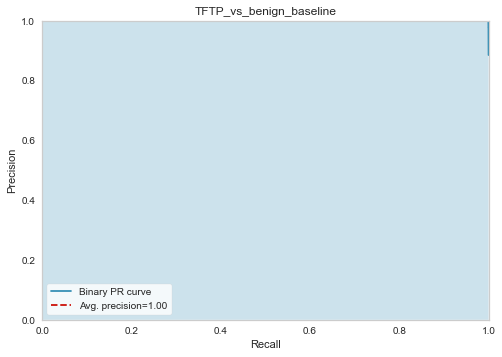

C:\ProgramData\Anaconda3\lib\site-packages\yellowbrick\classifier\base.py:234: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  YellowbrickWarning,


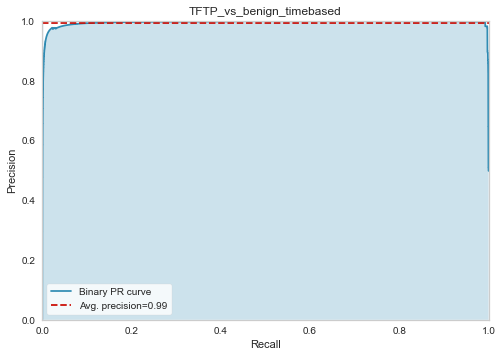

In [26]:
visualize_report(results[Baseline])
visualize_report(results[Timebased])
visualize_confusion_matrix(results[Baseline])
visualize_confusion_matrix(results[Timebased])
visualize_roc(results[Baseline])
visualize_roc(results[Timebased])
visualize_pr_curve(results[Baseline])
visualize_pr_curve(results[Timebased])

## Experiment #11: UDP vs Benign

Loading Dataset: ../data/prepared/baseline/UDP_vs_benign.csv
	To Dataset Cache: ../data/cache/baseline/UDP_vs_benign.csv.pickle

Loading Dataset: ../data/prepared/timebased/UDP_vs_benign.csv
	To Dataset Cache: ../data/cache/timebased/UDP_vs_benign.csv.pickle

Running experiment #11:	UDP
Baseline results
UDP_vs_benign_baseline: (225462, 70)


epoch,train_loss,valid_loss,accuracy,time
0,0.001343,0.023968,0.999690,00:24
1,0.002311,0.001491,0.999778,00:24
2,0.002780,0.001076,0.999800,00:24
3,0.001793,0.000901,0.999800,00:24
4,0.000327,0.000902,0.999800,00:24
5,0.000351,0.000794,0.999800,00:24
6,0.000174,0.000625,0.999889,00:24
7,0.002497,0.000722,0.999845,00:24
8,0.001884,0.000559,0.999911,00:26
9,0.000176,0.000514,0.999911,00:24


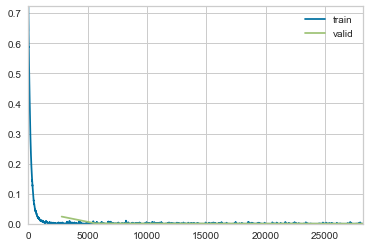

loss 0.0005142762674950063: accuracy: 99.99%

Time-based results
UDP_vs_benign_timebased: (225462, 26)


epoch,train_loss,valid_loss,accuracy,time
0,0.078231,0.289674,0.952918,00:22
1,0.059116,1.157205,0.707775,00:22
2,0.053177,1.088731,0.681895,00:22
3,0.039490,0.627605,0.708485,00:22
4,0.038250,0.302503,0.710924,00:24
5,0.032699,0.819144,0.707243,00:23
6,0.035636,1.107173,0.707797,00:22
7,0.039552,0.974441,0.707642,00:22
8,0.031459,0.888795,0.705957,00:22
9,0.024912,1.049517,0.707975,00:22


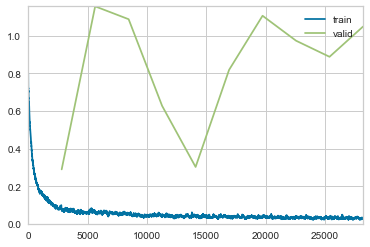

loss 1.0495169162750244: accuracy: 70.80%


In [27]:
results = next(experiment)

C:\ProgramData\Anaconda3\lib\site-packages\yellowbrick\classifier\base.py:234: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  YellowbrickWarning,


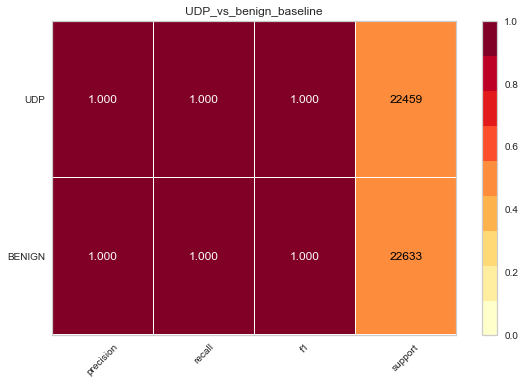

C:\ProgramData\Anaconda3\lib\site-packages\yellowbrick\classifier\base.py:234: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  YellowbrickWarning,


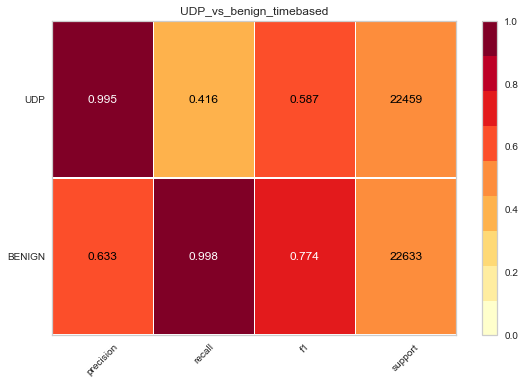

C:\ProgramData\Anaconda3\lib\site-packages\yellowbrick\classifier\base.py:234: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  YellowbrickWarning,


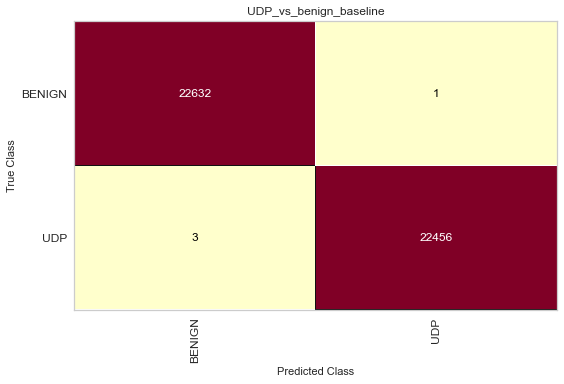

C:\ProgramData\Anaconda3\lib\site-packages\yellowbrick\classifier\base.py:234: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  YellowbrickWarning,


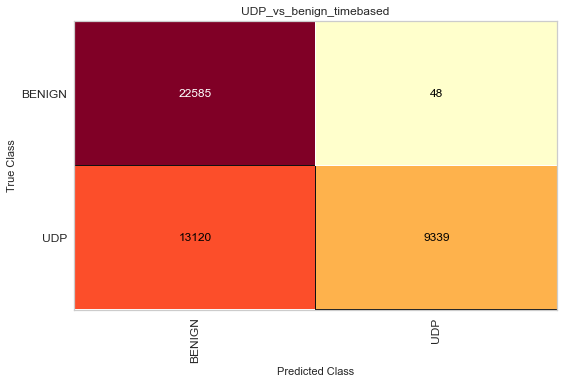

C:\ProgramData\Anaconda3\lib\site-packages\yellowbrick\classifier\base.py:234: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  YellowbrickWarning,


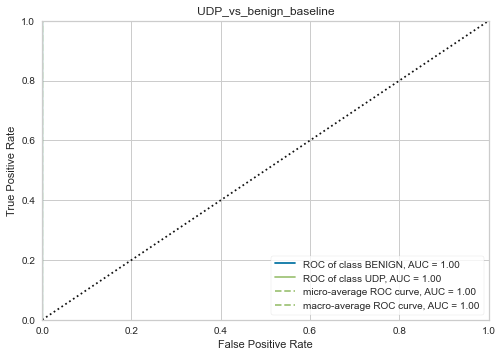

C:\ProgramData\Anaconda3\lib\site-packages\yellowbrick\classifier\base.py:234: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  YellowbrickWarning,


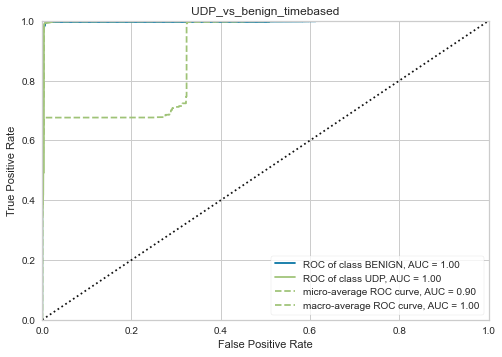

C:\ProgramData\Anaconda3\lib\site-packages\yellowbrick\classifier\base.py:234: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  YellowbrickWarning,


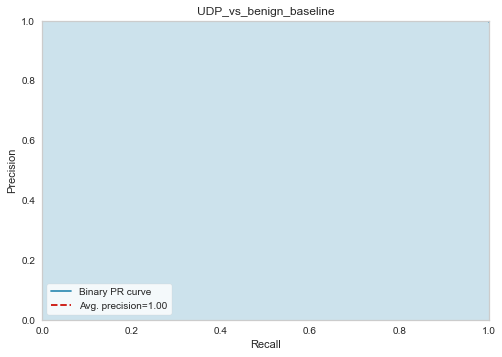

C:\ProgramData\Anaconda3\lib\site-packages\yellowbrick\classifier\base.py:234: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  YellowbrickWarning,


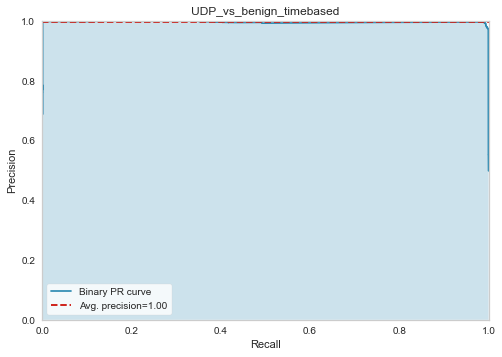

In [28]:
visualize_report(results[Baseline])
visualize_report(results[Timebased])
visualize_confusion_matrix(results[Baseline])
visualize_confusion_matrix(results[Timebased])
visualize_roc(results[Baseline])
visualize_roc(results[Timebased])
visualize_pr_curve(results[Baseline])
visualize_pr_curve(results[Timebased])

## Experiment #12: UDP-lag vs Benign

Loading Dataset: ../data/prepared/baseline/UDPLag_vs_benign.csv
	To Dataset Cache: ../data/cache/baseline/UDPLag_vs_benign.csv.pickle

Loading Dataset: ../data/prepared/timebased/UDPLag_vs_benign.csv
	To Dataset Cache: ../data/cache/timebased/UDPLag_vs_benign.csv.pickle

Running experiment #12:	UDPLag
Baseline results
UDPLag_vs_benign_baseline: (225462, 70)


epoch,train_loss,valid_loss,accuracy,time
0,0.012643,0.058227,0.998026,00:24
1,0.005351,0.094273,0.997516,00:24
2,0.006273,0.079571,0.998536,00:24
3,0.006354,0.087143,0.998625,00:24
4,0.003260,0.104947,0.998403,00:24
5,0.005284,0.077055,0.997139,00:24
6,0.004367,0.073504,0.999490,00:24
7,0.003285,0.113842,0.999468,00:24
8,0.001905,0.039500,0.999379,00:24
9,0.002282,0.114936,0.998980,00:24


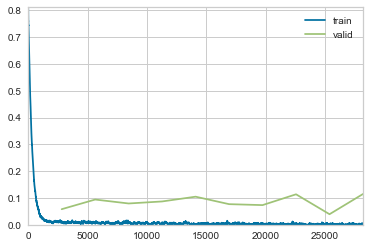

loss 0.11493556946516037: accuracy: 99.90%

Time-based results
UDPLag_vs_benign_timebased: (225462, 26)


epoch,train_loss,valid_loss,accuracy,time
0,0.274868,0.331705,0.849863,00:22
1,0.238671,0.449853,0.856671,00:22
2,0.181953,0.805743,0.857447,00:22
3,0.156535,0.387153,0.858556,00:22
4,0.150730,1.024853,0.632041,00:24
5,0.155484,0.735916,0.633660,00:22
6,0.126541,0.749611,0.632729,00:22
7,0.123758,1.211816,0.632973,00:22
8,0.109037,0.503327,0.633483,00:22
9,0.111107,0.600989,0.633083,00:23


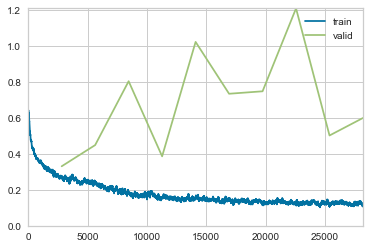

loss 0.6009887456893921: accuracy: 63.31%


In [29]:
results = next(experiment)

C:\ProgramData\Anaconda3\lib\site-packages\yellowbrick\classifier\base.py:234: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  YellowbrickWarning,


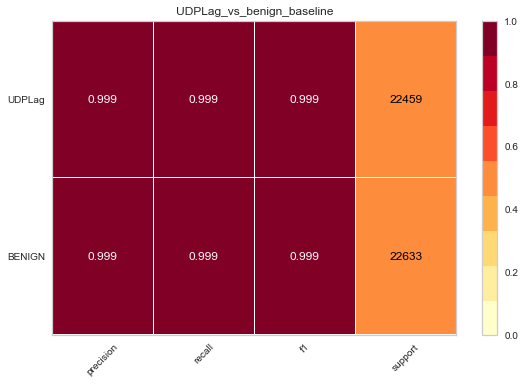

C:\ProgramData\Anaconda3\lib\site-packages\yellowbrick\classifier\base.py:234: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  YellowbrickWarning,


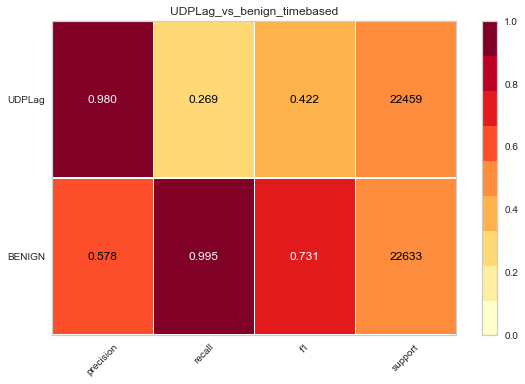

C:\ProgramData\Anaconda3\lib\site-packages\yellowbrick\classifier\base.py:234: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  YellowbrickWarning,


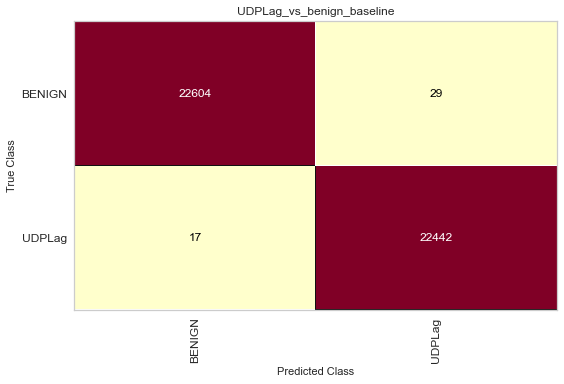

C:\ProgramData\Anaconda3\lib\site-packages\yellowbrick\classifier\base.py:234: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  YellowbrickWarning,


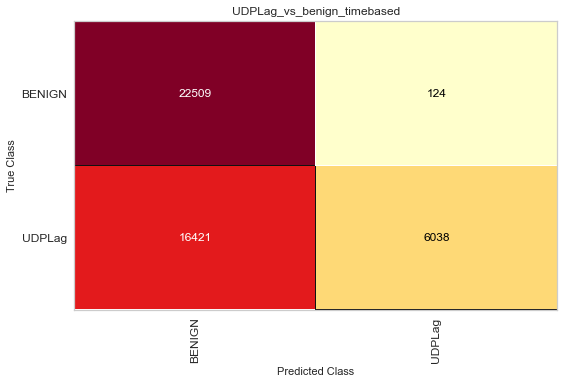

C:\ProgramData\Anaconda3\lib\site-packages\yellowbrick\classifier\base.py:234: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  YellowbrickWarning,


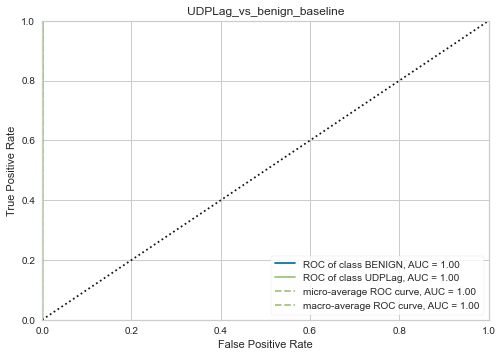

C:\ProgramData\Anaconda3\lib\site-packages\yellowbrick\classifier\base.py:234: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  YellowbrickWarning,


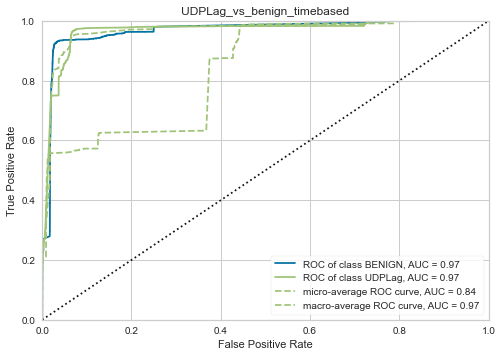

C:\ProgramData\Anaconda3\lib\site-packages\yellowbrick\classifier\base.py:234: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  YellowbrickWarning,


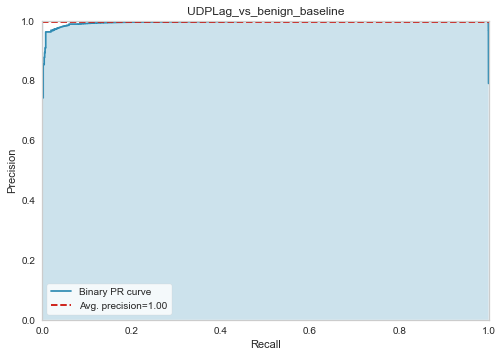

C:\ProgramData\Anaconda3\lib\site-packages\yellowbrick\classifier\base.py:234: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  YellowbrickWarning,


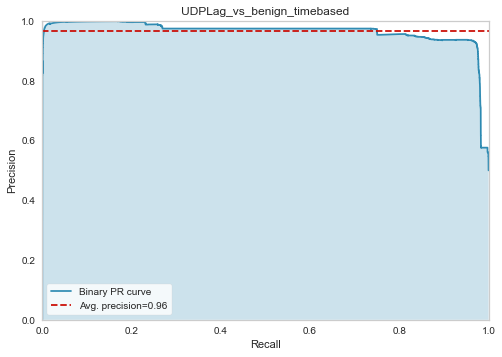

In [30]:
visualize_report(results[Baseline])
visualize_report(results[Timebased])
visualize_confusion_matrix(results[Baseline])
visualize_confusion_matrix(results[Timebased])
visualize_roc(results[Baseline])
visualize_roc(results[Timebased])
visualize_pr_curve(results[Baseline])
visualize_pr_curve(results[Timebased])